In [1]:
# what's the computational trade-off for taking a systematica approach
# some suggestions for what should be reported (how much etc.)

In [1]:
# https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0237073
# https://www.emerald.com/insight/content/doi/10.1108/OIR-11-2012-0124/full/html#idm45525604636784
# https://link.springer.com/article/10.1007/s41109-022-00446-2
# https://www.sciencedirect.com/science/article/pii/S0950329320302627
# News-Topic Oriented Hashtag Recommendation in Twitter Based on Characteristic Co-occurrence Word Detection
# https://www.analyticsvidhya.com/blog/2021/06/twitter-sentiment-analysis-a-nlp-use-case-for-beginners/#Twitter_Sentiment_Analysis:_Project_Pipeline

In [23]:
import pandas as pd
import numpy as np
import networkx as nx
import xml.etree.ElementTree as ET
import itertools
from matplotlib import pyplot as plt
from itertools import combinations
import math

In [2]:
# replaced each '&' with 'amp;'

In [3]:
tree1_1 = ET.parse('conf1_1_combine.xml')
root1_1 = tree1_1.getroot()

tree1_2 = ET.parse('conf1_2_combine.xml')
root1_2 = tree1_2.getroot()

tree1_3 = ET.parse('conf1_3_combine.xml')
root1_3 = tree1_3.getroot()

tree2_2 = ET.parse('conf2_2_combine.xml')
root2_2 = tree2_2.getroot()

tree2_3 = ET.parse('conf2_3_combine.xml')
root2_3 = tree2_3.getroot()

tree3_3 = ET.parse('conf3_3_combine.xml')
root3_3 = tree3_3.getroot()
#num_tweets = len(root)
#ids = [x[0].text[1:-1] for x in root]

In [4]:
def find_tweets(root, lower_compound_threshold, upper_compound_threshold):
    selected_tweets = []
    ind = 0
    for tweet in root:
        compound_score = float(tweet[1].text[tweet[1].text.find('compound')+11:tweet[1].text.find('}')])
        if compound_score < upper_compound_threshold and compound_score > lower_compound_threshold:
            selected_tweets.append(ind)
        ind += 1
    
    return selected_tweets

In [5]:
def create_graph(root, score_threshold, noisy_keywords = None):
    keyword_count = dict()
    keyword_pairs_counts = dict()
    keyword_scores = dict()
    for tweet in root:
        keywords = []
        for keyword_score_pair in tweet[2:]:
            score = float(keyword_score_pair.text[1:keyword_score_pair.text.find(',')])
            keyword = keyword_score_pair.text[keyword_score_pair.text.find(',')+3:keyword_score_pair.text.find(')')-1]
            if keyword not in keywords:
                keywords.append(keyword)
                if keyword in keyword_count:
                    keyword_count[keyword] += 1
                else:
                    keyword_count[keyword] = 1
            keyword_scores[keyword] = score
                        
        exclude_keywords = []
        for keyword_pair in list(combinations(keywords, 2)):
            if keyword_pair[0] in keyword_pair[1]:
                exclude_keywords.append(keyword_pair[0])
            elif keyword_pair[1] in keyword_pair[0]:
                exclude_keywords.append(keyword_pair[1])

        for keyword in exclude_keywords:
            if keyword in keywords:
                keywords.remove(keyword)
                keyword_count[keyword] -= 1
        
        for keyword_pair in list(combinations(keywords, 2)):
            if frozenset(keyword_pair) in keyword_pairs_counts:
                keyword_pairs_counts[frozenset(keyword_pair)] += 1
            else:
                keyword_pairs_counts[frozenset(keyword_pair)] = 1
    
    G = nx.Graph()
    G.add_nodes_from(list(keyword_count.keys()))
    nx.set_node_attributes(G, keyword_count, name="count")

    for edge_to_add in keyword_pairs_counts:
        nodes = list(edge_to_add)
        G.add_edge(nodes[0], nodes[1], weight = keyword_pairs_counts[edge_to_add])
        
    remove_count = [node for node,count in nx.get_node_attributes(G, 'count').items() if count == 1]
    remove_score = [node for node,score in keyword_scores.items() if score < score_threshold]
    remove = list(set(remove_count) & set(remove_score))
    G.remove_nodes_from(remove)
    
    if noisy_keywords:
        G.remove_nodes_from(noisy_keywords)
        
    return(G)

In [6]:
# we define the positive, neutral, and negative tweets based on their compound sentiment score
# this is the score used often in the literature

In [7]:
positive_tweets = find_tweets(root1_1, 0.05, 1)
negative_tweets = find_tweets(root1_1, -1, -0.05)
neutral_tweets = find_tweets(root1_1, -0.05, 0.05)

positive_tweets_add = find_tweets(root2_2, 0.05, 1)
negative_tweets_add = find_tweets(root2_2, -1, -0.05)
neutral_tweets_add = find_tweets(root2_2, -0.05, 0.05)

In [8]:
4947/len(positive_tweets)

2.032456861133936

In [9]:
4002/len(negative_tweets)

1.837465564738292

In [10]:
6847/len(neutral_tweets)

1.5389975275342773

In [11]:
12326/len(root1_1)

1.3603355038075267

In [12]:
len(root1_1)

9061

In [13]:
len(root2_2)

8616

In [14]:
# the score threshold does not apply to the 1 gram keywords, so we split our analysis in two
# we first compare the networks created using different ngram lengths and then compare what effect the score threshold can have

In [15]:
noisy_keywords = ['rt']

In [16]:
noisy_keywords = ['rt', 'amp', '…', 'co', 'https ://', '’', '.…']

In [17]:
score_thresholds = [1, 2, 5]

In [18]:
all_graphs = {}
for score_threshold in score_thresholds:
    all_graphs['graph_pos_11_' + str(score_threshold)] = create_graph([root1_1[i] for i in positive_tweets], score_threshold, noisy_keywords)
    all_graphs['graph_neg_11_' + str(score_threshold)] = create_graph([root1_1[i] for i in negative_tweets], score_threshold, noisy_keywords)
    all_graphs['graph_neu_11_' + str(score_threshold)] = create_graph([root1_1[i] for i in neutral_tweets], score_threshold, noisy_keywords)
    all_graphs['graph_all_11_' + str(score_threshold)] = create_graph(root1_1, score_threshold, noisy_keywords)
    
    all_graphs['graph_pos_12_' + str(score_threshold)] = create_graph([root1_2[i] for i in positive_tweets], score_threshold, noisy_keywords)
    all_graphs['graph_neg_12_' + str(score_threshold)] = create_graph([root1_2[i] for i in negative_tweets], score_threshold, noisy_keywords)
    all_graphs['graph_neu_12_' + str(score_threshold)] = create_graph([root1_2[i] for i in neutral_tweets], score_threshold, noisy_keywords)
    all_graphs['graph_all_12_' + str(score_threshold)] = create_graph(root1_2, score_threshold, noisy_keywords)
    
    all_graphs['graph_pos_13_' + str(score_threshold)] = create_graph([root1_3[i] for i in positive_tweets], score_threshold, noisy_keywords)
    all_graphs['graph_neg_13_' + str(score_threshold)] = create_graph([root1_3[i] for i in negative_tweets], score_threshold, noisy_keywords)
    all_graphs['graph_neu_13_' + str(score_threshold)] = create_graph([root1_3[i] for i in neutral_tweets], score_threshold, noisy_keywords)
    all_graphs['graph_all_13_' + str(score_threshold)] = create_graph(root1_3, score_threshold, noisy_keywords)
    
    all_graphs['graph_pos_22_' + str(score_threshold)] = create_graph([root2_2[i] for i in positive_tweets_add], score_threshold, noisy_keywords)
    all_graphs['graph_neg_22_' + str(score_threshold)] = create_graph([root2_2[i] for i in negative_tweets_add], score_threshold, noisy_keywords)
    all_graphs['graph_neu_22_' + str(score_threshold)] = create_graph([root2_2[i] for i in neutral_tweets_add], score_threshold, noisy_keywords)
    all_graphs['graph_all_22_' + str(score_threshold)] = create_graph(root2_2, score_threshold, noisy_keywords)
    
    all_graphs['graph_pos_23_' + str(score_threshold)] = create_graph([root2_3[i] for i in positive_tweets_add], score_threshold, noisy_keywords)
    all_graphs['graph_neg_23_' + str(score_threshold)] = create_graph([root2_3[i] for i in negative_tweets_add], score_threshold, noisy_keywords)
    all_graphs['graph_neu_23_' + str(score_threshold)] = create_graph([root2_3[i] for i in neutral_tweets_add], score_threshold, noisy_keywords)
    all_graphs['graph_all_23_' + str(score_threshold)] = create_graph(root2_3, score_threshold, noisy_keywords)
    
    all_graphs['graph_pos_33_' + str(score_threshold)] = create_graph([root3_3[i] for i in positive_tweets_add], score_threshold, noisy_keywords)
    all_graphs['graph_neg_33_' + str(score_threshold)] = create_graph([root3_3[i] for i in negative_tweets_add], score_threshold, noisy_keywords)
    all_graphs['graph_neu_33_' + str(score_threshold)] = create_graph([root3_3[i] for i in neutral_tweets_add], score_threshold, noisy_keywords)
    all_graphs['graph_all_33_' + str(score_threshold)] = create_graph(root3_3, score_threshold, noisy_keywords)

In [19]:
len(all_graphs)

72

In [20]:
def generate_network_prop_table(graphs):
    network_prop_df = pd.DataFrame(columns = ['setup', 'nodes', 'edges', 'edge_weight', 'components'])
    for setup in graphs:
        graph = graphs[setup]
        num_nodes = len(graph.nodes())
        num_edges = len(graph.edges())
        edge_weight = graph.size(weight='weight')
        component_sizes = [len(c) for c in sorted(nx.connected_components(graph), key=len, reverse=True)]
        
        network_prop_df = pd.concat([network_prop_df, pd.DataFrame.from_dict({'setup': setup, 'nodes': [num_nodes], 'edges': [num_edges]
                                            ,'edge_weight': [edge_weight], 'components': [component_sizes]})], ignore_index = True)
        
    return network_prop_df

In [21]:
no_score_thresh_graphs = {key: all_graphs[key] for key in [key for key in all_graphs.keys() if key[-1] == '1']}

In [22]:
# the length 1 keywork networks are subsets of the length 2, which are subsets of the length 3
# in all cases, the largest component of the network makes up the vast majority of the graph

In [23]:
#no_score_thresh_graphs = {key: all_graphs[key] for key in [key for key in all_graphs.keys() if '33' in key]}

In [24]:
generate_network_prop_table(no_score_thresh_graphs)

,setup,nodes,edges,edge_weight,components
0,graph_pos_11_1,4947,21795,25389.0,"[4420, 9, 8, 8, 7, 7, 6, 5, 5, 5, 5, 5, 5, 5, ..."
1,graph_neg_11_1,4002,16139,20519.0,"[3341, 10, 10, 8, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6..."
2,graph_neu_11_1,6847,17586,21368.0,"[4548, 34, 27, 15, 14, 13, 13, 12, 10, 10, 10,..."
3,graph_all_11_1,12326,54052,67276.0,"[10129, 17, 15, 13, 13, 12, 10, 10, 9, 9, 9, 8..."
4,graph_pos_12_1,8669,43724,50169.0,"[7868, 12, 11, 11, 10, 10, 9, 8, 8, 7, 7, 7, 7..."
5,graph_neg_12_1,6975,33225,40380.0,"[6063, 13, 11, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 7..."
6,graph_neu_12_1,10935,35550,41849.0,"[7894, 20, 19, 18, 14, 14, 14, 14, 13, 12, 12,..."
7,graph_all_12_1,22606,110807,132398.0,"[19489, 25, 18, 14, 14, 12, 12, 11, 11, 11, 11..."
8,graph_pos_13_1,10258,53186,60634.0,"[9269, 14, 14, 12, 10, 10, 10, 9, 9, 8, 8, 8, ..."
9,graph_neg_13_1,8315,41022,48976.0,"[7192, 15, 12, 11, 10, 10, 9, 9, 9, 9, 9, 9, 9..."


In [25]:
thresh_graphs = {key: all_graphs[key] for key in [key for key in all_graphs.keys() if (key[-1] == '5' or key[-1] == '2') and 'all' in key]}

In [26]:
generate_network_prop_table(thresh_graphs)

,setup,nodes,edges,edge_weight,components
0,graph_all_11_2,4784,31299,44523.0,"[4360, 8, 6, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."
1,graph_all_12_2,15092,76071,97662.0,"[13462, 11, 11, 11, 9, 8, 8, 8, 8, 7, 7, 7, 7,..."
2,graph_all_13_2,20353,98496,123569.0,"[17775, 22, 17, 14, 11, 11, 11, 10, 10, 9, 9, ..."
3,graph_all_22_2,10296,10339,11221.0,"[2076, 28, 22, 20, 20, 17, 17, 17, 16, 16, 16,..."
4,graph_all_23_2,15524,20234,21966.0,"[3280, 34, 27, 26, 26, 24, 23, 21, 21, 20, 18,..."
5,graph_all_33_2,5230,1669,1807.0,"[7, 7, 6, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."
6,graph_all_11_5,4784,31299,44523.0,"[4360, 8, 6, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."
7,graph_all_12_5,6479,44467,66058.0,"[5981, 9, 9, 8, 8, 7, 7, 6, 6, 5, 5, 5, 5, 5, ..."
8,graph_all_13_5,11739,61279,86352.0,"[10304, 15, 14, 12, 9, 9, 9, 8, 7, 7, 7, 7, 7,..."
9,graph_all_22_5,1272,1231,2113.0,"[495, 10, 8, 7, 6, 6, 6, 5, 5, 5, 5, 4, 4, 4, ..."


In [27]:
def plot_graph_fun(graphs, fun, axis, offset, labels, sentiment, fun_arg = None):
    i = 0
    for setup in graphs:
        graph = graphs[setup]
        
        nx_fun = getattr(nx, fun)
        
        if fun_arg:
            fun_vals = sorted(list(nx_fun(graph, fun_arg).values()))[:-offset]
            cum_distr = np.arange(len(fun_vals))/float(len(fun_vals))
        
        else:
            fun_vals = sorted(list(nx_fun(graph).values()))[:-offset]
            cum_distr = np.arange(len(fun_vals))/float(len(fun_vals))
        
        axis.plot(fun_vals, cum_distr, label = labels[i])
        i += 1
    axis.set_title(sentiment)
    
def plot_graph_fun_dict(graphs, fun, axis, offset, labels, sentiment, fun_arg = None):
    i = 0
    for setup in graphs:
        graph = graphs[setup]
        
        nx_fun = getattr(nx, fun)
        
        if fun_arg:
            fun_vals = sorted(list(dict(nx_fun(graph, fun_arg)).values()))[:-offset]
            cum_distr = np.arange(len(fun_vals))/float(len(fun_vals))
        
        else:
            fun_vals = sorted(list(nx_fun(graph).values()))[:-offset]
            cum_distr = np.arange(len(fun_vals))/float(len(fun_vals))
        
        axis.plot(fun_vals, cum_distr, label = labels[i])
        i += 1
    axis.set_title(sentiment)
    
pos_no_thresh_graphs = {key: all_graphs[key] for key in ['graph_pos_11_1', 'graph_pos_12_1', 'graph_pos_13_1']}
neg_no_thresh_graphs = {key: all_graphs[key] for key in ['graph_neg_11_1', 'graph_neg_12_1', 'graph_neg_13_1']}
neu_no_thresh_graphs = {key: all_graphs[key] for key in ['graph_neu_11_1', 'graph_neu_12_1', 'graph_neu_13_1']}
all_no_thresh_graphs = {key: all_graphs[key] for key in ['graph_all_11_1', 'graph_all_12_1', 'graph_all_13_1']}

pos_low_thresh_graphs = {key: all_graphs[key] for key in ['graph_pos_11_2', 'graph_pos_12_2', 'graph_pos_13_2']}
neg_low_thresh_graphs = {key: all_graphs[key] for key in ['graph_neg_11_2', 'graph_neg_12_2', 'graph_neg_13_2']}
neu_low_thresh_graphs = {key: all_graphs[key] for key in ['graph_neu_11_2', 'graph_neu_12_2', 'graph_neu_13_2']}
all_low_thresh_graphs = {key: all_graphs[key] for key in ['graph_all_11_2', 'graph_all_12_2', 'graph_all_13_2']}

pos_med_thresh_graphs = {key: all_graphs[key] for key in ['graph_pos_11_5', 'graph_pos_12_5', 'graph_pos_13_5']}
neg_med_thresh_graphs = {key: all_graphs[key] for key in ['graph_neg_11_5', 'graph_neg_12_5', 'graph_neg_13_5']}
neu_med_thresh_graphs = {key: all_graphs[key] for key in ['graph_neu_11_5', 'graph_neu_12_5', 'graph_neu_13_5']}
all_med_thresh_graphs = {key: all_graphs[key] for key in ['graph_all_11_5', 'graph_all_12_5', 'graph_all_13_5']}

In [20]:
all_full_graphs = {key: all_graphs[key] for key in ['graph_all_11_1', 'graph_all_12_1', 'graph_all_13_1',
                                                      'graph_all_11_2', 'graph_all_12_2', 'graph_all_13_2',
                                                      'graph_all_11_5', 'graph_all_12_5', 'graph_all_13_5']}

all_pos_neg_graphs = {key: all_graphs[key] for key in ['graph_pos_11_1', 'graph_pos_12_1', 'graph_pos_13_1',
                                                      'graph_neg_11_1', 'graph_neg_12_1', 'graph_neg_13_1',
                                                      'graph_pos_11_2', 'graph_pos_12_2', 'graph_pos_13_2',
                                                      'graph_neg_11_2', 'graph_neg_12_2', 'graph_neg_13_2',
                                                      'graph_pos_11_5', 'graph_pos_12_5', 'graph_pos_13_5',
                                                      'graph_neg_11_5', 'graph_neg_12_5', 'graph_neg_13_5']}

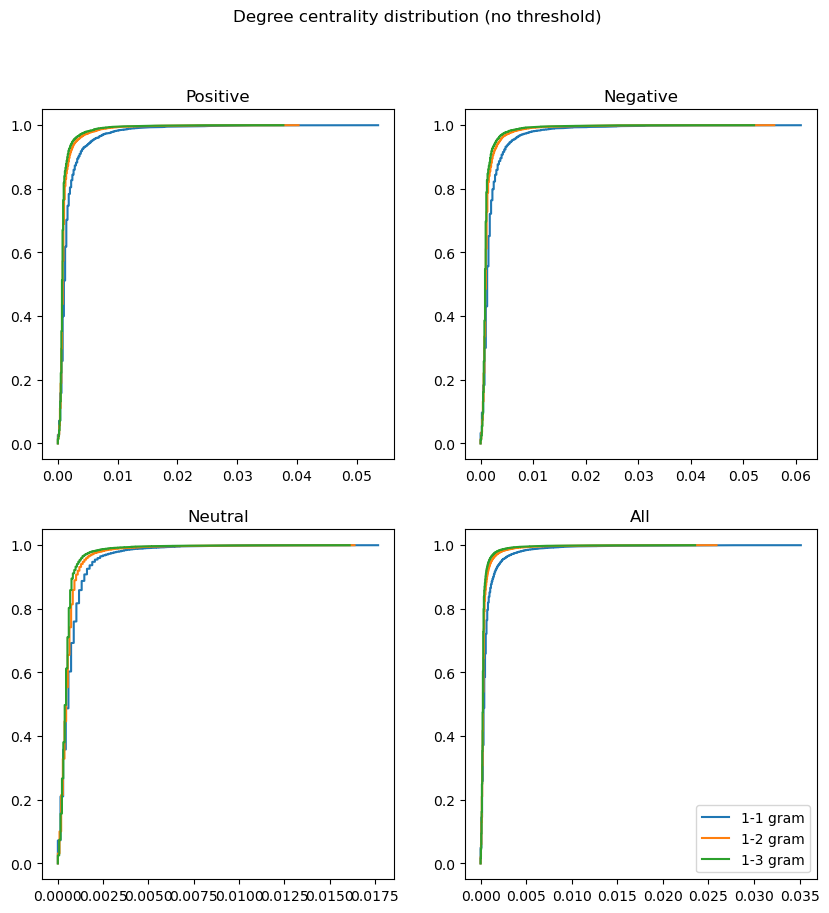

In [28]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 10))

plot_graph_fun(pos_no_thresh_graphs, 'degree_centrality', axes[0,0], 1, ['1-1 gram', '1-2 gram', '1-3 gram'], 'Positive')
plot_graph_fun(neg_no_thresh_graphs, 'degree_centrality', axes[0,1], 1, ['1-1 gram', '1-2 gram', '1-3 gram'], 'Negative')
plot_graph_fun(neu_no_thresh_graphs, 'degree_centrality', axes[1,0], 1, ['1-1 gram', '1-2 gram', '1-3 gram'], 'Neutral')
plot_graph_fun(all_no_thresh_graphs, 'degree_centrality', axes[1,1], 1, ['1-1 gram', '1-2 gram', '1-3 gram'], 'All')
axes[1,1].legend()
fig.suptitle('Degree centrality distribution (no threshold)')
plt.savefig('deg_cent_no_thresh.pdf')

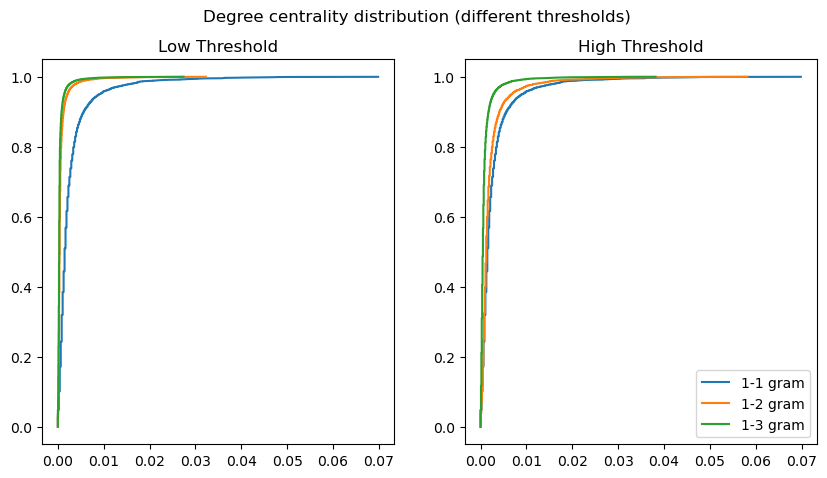

In [29]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))

plot_graph_fun(all_low_thresh_graphs, 'degree_centrality', axes[0], 1, ['1-1 gram', '1-2 gram', '1-3 gram'], 'Low Threshold')
plot_graph_fun(all_med_thresh_graphs, 'degree_centrality', axes[1], 1, ['1-1 gram', '1-2 gram', '1-3 gram'], 'High Threshold')

axes[1].legend()
fig.suptitle('Degree centrality distribution (different thresholds)')
plt.savefig('deg_cent_diff_thresh.pdf')

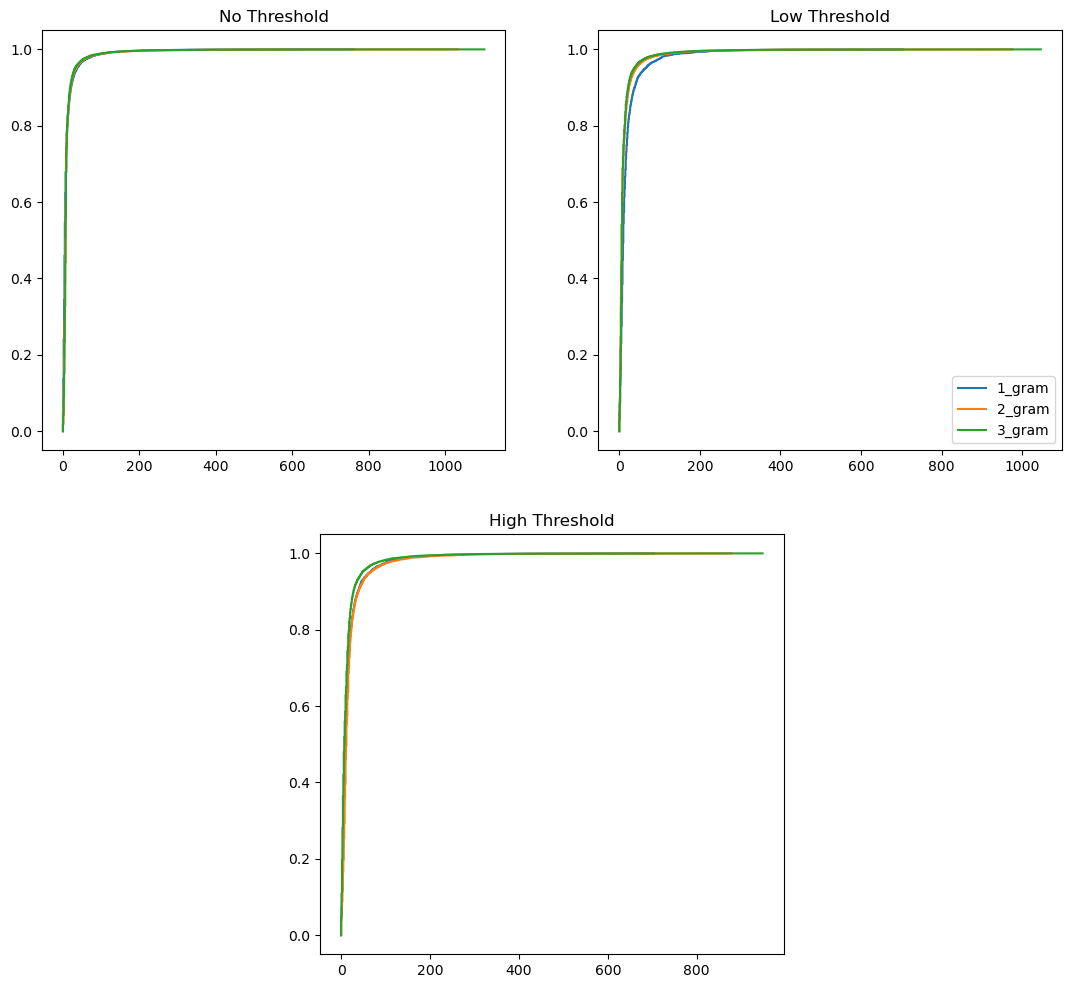

In [30]:
def plot_graph_strength(graphs, axis, offset, labels, sentiment):
    i = 0
    for setup in graphs:
        graph = graphs[setup]
        
        fun_vals = sorted(list(dict(nx.degree(graph, weight = 'weight')).values()))[:-offset]
        cum_distr = np.arange(len(fun_vals))/float(len(fun_vals))
        
        axis.plot(fun_vals, cum_distr, label = labels[i])
        i += 1
    axis.set_title(sentiment)

fig8 = plt.figure(constrained_layout=False, figsize=(12,12))
gs1 = fig8.add_gridspec(nrows=2, ncols=4, left=0.05)
gs1.update(wspace=0.5)

ax1 = plt.subplot(gs1[0, :2], )

plot_graph_strength(all_no_thresh_graphs, ax1, 1, ['1_gram', '2_gram', '3_gram'], 'No Threshold')
ax1.set_title('No Threshold')


ax2 = plt.subplot(gs1[0, 2:])

plot_graph_strength(all_low_thresh_graphs, ax2, 1, ['1_gram', '2_gram', '3_gram'], 'Low Threshold')
ax2.set_title('Low Threshold')


ax3 = plt.subplot(gs1[1, 1:3])

plot_graph_strength(all_med_thresh_graphs, ax3, 1, ['1_gram', '2_gram', '3_gram'], 'High Threshold')
ax3.set_title('High Threshold')


ax2.legend()

#ax1.text(-0.1, 0.95, string.ascii_uppercase[0], transform=ax1.transAxes, 
#            size=20, weight='bold')
#ax2.text(-0.1, 0.95, string.ascii_uppercase[1], transform=ax2.transAxes, 
#            size=20, weight='bold')
#ax3.text(-0.1, 0.95, string.ascii_uppercase[2], transform=ax3.transAxes, 
#            size=20, weight='bold')

plt.savefig('node_str_diff_thresh.pdf')
plt.show()

In [31]:
# measuring the tendency of nodes to connect to each other based on certain attributes

def generate_network_assort_table(graphs):
    network_prop_df = pd.DataFrame(columns = ['setup', 'strength', 'degree', 'count'])
    for setup in graphs:
        graph = graphs[setup]
        strength = nx.degree_assortativity_coefficient(graph, weight = 'weight')
        degree_coeff = nx.degree_assortativity_coefficient(graph)
        count_coeff = nx.attribute_assortativity_coefficient(graph, 'count')
        
        network_prop_df = pd.concat([network_prop_df, pd.DataFrame.from_dict({'setup': setup, 'strength': [strength], 'degree': [degree_coeff]
                                            ,'count': [count_coeff]})], ignore_index = True)
        
    return network_prop_df

In [32]:
generate_network_assort_table(thresh_graphs)

,setup,strength,degree,count
0,graph_all_11_2,-0.018607,-0.006406,0.012591
1,graph_all_12_2,-0.019712,-0.016889,0.032185
2,graph_all_13_2,-0.016056,-0.013394,0.049934
3,graph_all_22_2,-0.022114,-0.029024,0.152372
4,graph_all_23_2,-0.017333,-0.022741,0.197075
5,graph_all_33_2,0.815191,0.796098,0.499287
6,graph_all_11_5,-0.018607,-0.006406,0.012591
7,graph_all_12_5,-0.022267,-0.012263,0.022310
8,graph_all_13_5,-0.019688,-0.012608,0.036633
9,graph_all_22_5,0.092169,0.076906,0.135697


In [21]:
def sorted_cent(graphs, topN, calc_eig = False, calc_close = False):
    degCent_df = pd.DataFrame()
    nodeStr_df = pd.DataFrame()
    eigCent_df = pd.DataFrame()
    closeCent_df = pd.DataFrame()
    
    for setup in graphs:
        
        graph = graphs[setup]

        degCent = nx.degree_centrality(graph)
        degCent_sorted=dict(sorted(degCent.items(), key=lambda item: item[1],reverse=True))
        
        degCent_df[setup] = list(degCent_sorted.keys())[0:topN]
        
        #Computing node strength
        nodeStr = nx.degree(graph, weight = 'weight')
        nodeStr_sorted = dict(sorted(dict(nodeStr).items(), key=lambda item: item[1],reverse=True))
        
        nodeStr_df[setup] = list(nodeStr_sorted.keys())[0:topN]

        if calc_eig:
        #Computing betweeness
            eigCent = nx.eigenvector_centrality_numpy(graph, weight='weight')
            eigCent_sorted=dict(sorted(eigCent.items(), key=lambda item: item[1],reverse=True))

            eigCent_df[setup] = list(eigCent_sorted.keys())[0:topN]

        if calc_close:
        #Computing betweeness
            closeCent = nx.closeness_centrality(graph)
            closeCent_sorted=dict(sorted(closeCent.items(), key=lambda item: item[1],reverse=True))

            closeCent_df[setup] = list(closeCent_sorted.keys())[0:topN]
        
    return degCent_df, nodeStr_df, eigCent_df, closeCent_df

In [35]:
degCent_all_df, nodeStr_all_df, pos_eigCent_df, pos_closeCent_df = sorted_cent(all_full_graphs, 1400)
degCent_posneg_df, nodeStr_posneg_df, pos_eigCent_df, pos_closeCent_df = sorted_cent(all_pos_neg_graphs, 1400)

In [24]:
def rbo(S,T, p= 0.9):
    """ Takes two lists S and T of any lengths and gives out the RBO Score
    Parameters
    ----------
    S, T : Lists (str, integers)
    p : Weight parameter, giving the influence of the first d
        elements on the final score. p<0<1. Default 0.9 give the top 10 
        elements 86% of the contribution in the final score.
    
    Returns
    -------
    Float of RBO score
    """
    
    # Fixed Terms
    k = max(len(S), len(T))
    x_k = len(set(S).intersection(set(T)))
    
    summation_term = 0

    # Loop for summation
    # k+1 for the loop to reach the last element (at k) in the bigger list    
    for d in range (1, k+1): 
            # Create sets from the lists
            set1 = set(S[:d]) if d < len(S) else set(S)
            set2 = set(T[:d]) if d < len(T) else set(T)
            
            # Intersection at depth d
            x_d = len(set1.intersection(set2))

            # Agreement at depth d
            a_d = x_d/d   
            
            # Summation
            summation_term = summation_term + math.pow(p, d) * a_d

    # Rank Biased Overlap - extrapolated
    rbo_ext = (x_k/k) * math.pow(p, k) + ((1-p)/p * summation_term)

    return rbo_ext

def weightage_calculator(p,d):
    """ Takes values of p and d
    ----------
    p : Weight parameter, giving the influence of the first d
        elements on the final score. p<0<1.
    d : depth at which the weight has to be calculated
    
    Returns
    -------
    Float of Weightage Wrbo at depth d
    """

    summation_term = 0

    for i in range (1, d): # taking d here will loop upto the value d-1 
        summation_term = summation_term + math.pow(p,i)/i


    Wrbo_1_d = 1 - math.pow(p, d-1) + (((1-p)/p) * d *(np.log(1/(1-p)) - summation_term))

    return Wrbo_1_d

In [25]:
print(weightage_calculator(0.9, 13))
print(weightage_calculator(0.99, 130))

0.9079099164989892
0.9039562429806366


In [ ]:
# all_tweets networks show higher similarity values than positive or negative tweets

In [26]:
nodeStr_shortlist_result_df = pd.DataFrame(columns = nodeStr_all_df.columns, index = nodeStr_all_df.columns)

for col1 in nodeStr_all_df:
    for col2 in nodeStr_all_df:
        nodeStr_shortlist_result_df[col1][col2] = rbo(nodeStr_all_df[col1],nodeStr_all_df[col2], p = 0.9)
        
nodeStr_shortlist_result_df = nodeStr_shortlist_result_df.astype(float)

In [27]:
nodeStr_shortlist_result_df.round(3)

,graph_all_11_1,graph_all_12_1,graph_all_13_1,graph_all_11_2,graph_all_12_2,graph_all_13_2,graph_all_11_5,graph_all_12_5,graph_all_13_5
graph_all_11_1,1.000,0.957,0.938,0.964,0.943,0.927,0.964,0.922,0.903
graph_all_12_1,0.957,1.000,0.963,0.952,0.957,0.961,0.952,0.938,0.936
graph_all_13_1,0.938,0.963,1.000,0.934,0.937,0.951,0.934,0.913,0.920
graph_all_11_2,0.964,0.952,0.934,1.000,0.962,0.939,1.000,0.953,0.931
graph_all_12_2,0.943,0.957,0.937,0.962,1.000,0.959,0.962,0.971,0.957
graph_all_13_2,0.927,0.961,0.951,0.939,0.959,1.000,0.939,0.940,0.956
graph_all_11_5,0.964,0.952,0.934,1.000,0.962,0.939,1.000,0.953,0.931
graph_all_12_5,0.922,0.938,0.913,0.953,0.971,0.940,0.953,1.000,0.970
graph_all_13_5,0.903,0.936,0.920,0.931,0.957,0.956,0.931,0.970,1.000


In [28]:
nodeStr_longlist_result_df = pd.DataFrame(columns = nodeStr_all_df.columns, index = nodeStr_all_df.columns)

for col1 in nodeStr_all_df:
    for col2 in nodeStr_all_df:
        nodeStr_longlist_result_df[col1][col2] = rbo(nodeStr_all_df[col1],nodeStr_all_df[col2], p = 0.99)
        
nodeStr_longlist_result_df = nodeStr_longlist_result_df.astype(float)

In [29]:
nodeStr_longlist_result_df.round(3)

,graph_all_11_1,graph_all_12_1,graph_all_13_1,graph_all_11_2,graph_all_12_2,graph_all_13_2,graph_all_11_5,graph_all_12_5,graph_all_13_5
graph_all_11_1,1.000,0.879,0.871,0.939,0.874,0.866,0.939,0.843,0.838
graph_all_12_1,0.879,1.000,0.966,0.866,0.952,0.956,0.866,0.900,0.915
graph_all_13_1,0.871,0.966,1.000,0.856,0.936,0.954,0.856,0.884,0.907
graph_all_11_2,0.939,0.866,0.856,1.000,0.882,0.871,1.000,0.870,0.861
graph_all_12_2,0.874,0.952,0.936,0.882,1.000,0.962,0.882,0.937,0.942
graph_all_13_2,0.866,0.956,0.954,0.871,0.962,1.000,0.871,0.918,0.942
graph_all_11_5,0.939,0.866,0.856,1.000,0.882,0.871,1.000,0.870,0.861
graph_all_12_5,0.843,0.900,0.884,0.870,0.937,0.918,0.870,1.000,0.956
graph_all_13_5,0.838,0.915,0.907,0.861,0.942,0.942,0.861,0.956,1.000


In [ ]:
# pretty high robustness with node strength and deg cent, but lower than with all tweets

In [36]:
pos_nodeStr_df = nodeStr_posneg_df[[x for x in list(nodeStr_posneg_df.columns) if 'pos' in x]]

In [39]:
pos_nodeStr_shortlist_result_df = pd.DataFrame(columns = pos_nodeStr_df.columns, index = pos_nodeStr_df.columns)

for col1 in pos_nodeStr_df:
    for col2 in pos_nodeStr_df:
        pos_nodeStr_shortlist_result_df[col1][col2] = rbo(pos_nodeStr_df[col1],pos_nodeStr_df[col2], p = 0.9)
        
pos_nodeStr_shortlist_result_df = pos_nodeStr_shortlist_result_df.astype(float)

In [40]:
pos_nodeStr_shortlist_result_df.round(3)

,graph_pos_11_1,graph_pos_12_1,graph_pos_13_1,graph_pos_11_2,graph_pos_12_2,graph_pos_13_2,graph_pos_11_5,graph_pos_12_5,graph_pos_13_5
graph_pos_11_1,1.000,0.953,0.949,0.892,0.905,0.906,0.892,0.887,0.859
graph_pos_12_1,0.953,1.000,0.956,0.850,0.937,0.909,0.850,0.890,0.878
graph_pos_13_1,0.949,0.956,1.000,0.859,0.910,0.928,0.859,0.863,0.860
graph_pos_11_2,0.892,0.850,0.859,1.000,0.901,0.905,1.000,0.905,0.875
graph_pos_12_2,0.905,0.937,0.910,0.901,1.000,0.967,0.901,0.950,0.937
graph_pos_13_2,0.906,0.909,0.928,0.905,0.967,1.000,0.905,0.930,0.929
graph_pos_11_5,0.892,0.850,0.859,1.000,0.901,0.905,1.000,0.905,0.875
graph_pos_12_5,0.887,0.890,0.863,0.905,0.950,0.930,0.905,1.000,0.959
graph_pos_13_5,0.859,0.878,0.860,0.875,0.937,0.929,0.875,0.959,1.000


In [41]:
pos_nodeStr_longlist_result_df = pd.DataFrame(columns = pos_nodeStr_df.columns, index = pos_nodeStr_df.columns)

for col1 in pos_nodeStr_df:
    for col2 in pos_nodeStr_df:
        pos_nodeStr_longlist_result_df[col1][col2] = rbo(pos_nodeStr_df[col1],pos_nodeStr_df[col2], p = 0.99)
        
pos_nodeStr_longlist_result_df = pos_nodeStr_longlist_result_df.astype(float)

In [42]:
pos_nodeStr_longlist_result_df.round(3)

,graph_pos_11_1,graph_pos_12_1,graph_pos_13_1,graph_pos_11_2,graph_pos_12_2,graph_pos_13_2,graph_pos_11_5,graph_pos_12_5,graph_pos_13_5
graph_pos_11_1,1.000,0.900,0.889,0.901,0.880,0.871,0.901,0.832,0.830
graph_pos_12_1,0.900,1.000,0.960,0.843,0.933,0.927,0.843,0.855,0.862
graph_pos_13_1,0.889,0.960,1.000,0.837,0.918,0.938,0.837,0.843,0.867
graph_pos_11_2,0.901,0.843,0.837,1.000,0.877,0.863,1.000,0.882,0.867
graph_pos_12_2,0.880,0.933,0.918,0.877,1.000,0.955,0.877,0.907,0.909
graph_pos_13_2,0.871,0.927,0.938,0.863,0.955,1.000,0.863,0.888,0.916
graph_pos_11_5,0.901,0.843,0.837,1.000,0.877,0.863,1.000,0.882,0.867
graph_pos_12_5,0.832,0.855,0.843,0.882,0.907,0.888,0.882,1.000,0.944
graph_pos_13_5,0.830,0.862,0.867,0.867,0.909,0.916,0.867,0.944,1.000


In [43]:
neg_nodeStr_df = nodeStr_posneg_df[[x for x in list(nodeStr_posneg_df.columns) if 'neg' in x]]

In [44]:
neg_nodeStr_shortlist_result_df = pd.DataFrame(columns = neg_nodeStr_df.columns, index = neg_nodeStr_df.columns)

for col1 in neg_nodeStr_df:
    for col2 in neg_nodeStr_df:
        neg_nodeStr_shortlist_result_df[col1][col2] = rbo(neg_nodeStr_df[col1],neg_nodeStr_df[col2], p = 0.9)
        
neg_nodeStr_shortlist_result_df = neg_nodeStr_shortlist_result_df.astype(float)

In [45]:
neg_nodeStr_shortlist_result_df.round(3)

,graph_neg_11_1,graph_neg_12_1,graph_neg_13_1,graph_neg_11_2,graph_neg_12_2,graph_neg_13_2,graph_neg_11_5,graph_neg_12_5,graph_neg_13_5
graph_neg_11_1,1.000,0.937,0.947,0.939,0.913,0.928,0.939,0.876,0.899
graph_neg_12_1,0.937,1.000,0.976,0.934,0.964,0.971,0.934,0.918,0.945
graph_neg_13_1,0.947,0.976,1.000,0.928,0.948,0.967,0.928,0.902,0.930
graph_neg_11_2,0.939,0.934,0.928,1.000,0.930,0.936,1.000,0.899,0.924
graph_neg_12_2,0.913,0.964,0.948,0.930,1.000,0.973,0.930,0.951,0.973
graph_neg_13_2,0.928,0.971,0.967,0.936,0.973,1.000,0.936,0.931,0.957
graph_neg_11_5,0.939,0.934,0.928,1.000,0.930,0.936,1.000,0.899,0.924
graph_neg_12_5,0.876,0.918,0.902,0.899,0.951,0.931,0.899,1.000,0.965
graph_neg_13_5,0.899,0.945,0.930,0.924,0.973,0.957,0.924,0.965,1.000


In [46]:
neg_nodeStr_longlist_result_df = pd.DataFrame(columns = neg_nodeStr_df.columns, index = neg_nodeStr_df.columns)

for col1 in neg_nodeStr_df:
    for col2 in neg_nodeStr_df:
        neg_nodeStr_longlist_result_df[col1][col2] = rbo(neg_nodeStr_df[col1],neg_nodeStr_df[col2], p = 0.99)
        
neg_nodeStr_longlist_result_df = neg_nodeStr_longlist_result_df.astype(float)

In [47]:
neg_nodeStr_longlist_result_df.round(3)

,graph_neg_11_1,graph_neg_12_1,graph_neg_13_1,graph_neg_11_2,graph_neg_12_2,graph_neg_13_2,graph_neg_11_5,graph_neg_12_5,graph_neg_13_5
graph_neg_11_1,1.000,0.854,0.844,0.919,0.827,0.825,0.919,0.792,0.791
graph_neg_12_1,0.854,1.000,0.958,0.833,0.937,0.943,0.833,0.871,0.885
graph_neg_13_1,0.844,0.958,1.000,0.815,0.914,0.944,0.815,0.849,0.877
graph_neg_11_2,0.919,0.833,0.815,1.000,0.839,0.827,1.000,0.819,0.814
graph_neg_12_2,0.827,0.937,0.914,0.839,1.000,0.949,0.839,0.923,0.932
graph_neg_13_2,0.825,0.943,0.944,0.827,0.949,1.000,0.827,0.892,0.923
graph_neg_11_5,0.919,0.833,0.815,1.000,0.839,0.827,1.000,0.819,0.814
graph_neg_12_5,0.792,0.871,0.849,0.819,0.923,0.892,0.819,1.000,0.943
graph_neg_13_5,0.791,0.885,0.877,0.814,0.932,0.923,0.814,0.943,1.000


In [25]:
481/6450

0.07457364341085271

In [26]:
generate_network_prop_table(no_score_thresh_graphs)

,setup,nodes,edges,edge_weight,components
0,graph_pos_33_1,1589,485,518.0,"[4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..."
1,graph_neg_33_1,1341,453,500.0,"[5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."
2,graph_neu_33_1,2358,732,789.0,"[5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."
3,graph_all_33_1,5230,1669,1807.0,"[7, 7, 6, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."
4,graph_pos_33_2,1589,485,518.0,"[4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..."
5,graph_neg_33_2,1341,453,500.0,"[5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."
6,graph_neu_33_2,2358,732,789.0,"[5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."
7,graph_all_33_2,5230,1669,1807.0,"[7, 7, 6, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."
8,graph_pos_33_5,1589,485,518.0,"[4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..."
9,graph_neg_33_5,1341,453,500.0,"[5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."


In [27]:
low_thresh_graphs = {key: all_graphs[key] for key in [key for key in all_graphs.keys() if key[-1] == '2']}

In [28]:
generate_network_prop_table(low_thresh_graphs)

,setup,nodes,edges,edge_weight,components
0,graph_pos_11_2,1813,10640,14234.0,"[1709, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, ..."
1,graph_neg_11_2,1429,7871,12251.0,"[1341, 5, 4, 4, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, ..."
2,graph_neu_11_2,2167,6130,9912.0,"[1729, 12, 11, 8, 6, 5, 5, 5, 5, 4, 4, 4, 4, 4..."
3,graph_all_11_2,4784,31299,44523.0,"[4360, 8, 6, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."
4,graph_pos_12_2,5548,26769,33214.0,"[5110, 7, 7, 7, 6, 5, 5, 5, 5, 5, 5, 4, 4, 4, ..."
5,graph_neg_12_2,4413,20466,27621.0,"[3974, 9, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ..."
6,graph_neu_12_2,6273,17572,23871.0,"[4764, 11, 11, 11, 10, 10, 9, 8, 8, 8, 8, 7, 7..."
7,graph_all_12_2,15092,76071,97662.0,"[13462, 11, 11, 11, 9, 8, 8, 8, 8, 7, 7, 7, 7,..."
8,graph_pos_13_2,7147,34229,41677.0,"[6522, 9, 9, 8, 7, 7, 6, 6, 6, 6, 6, 6, 6, 5, ..."
9,graph_neg_13_2,5758,26415,34369.0,"[5108, 11, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6,..."


In [29]:
high_thresh_graphs = {key: all_graphs[key] for key in [key for key in all_graphs.keys() if key[-1] == '5']}

In [30]:
generate_network_prop_table(high_thresh_graphs)

,setup,nodes,edges,edge_weight,components
0,graph_pos_11_5,1813,10640,14234.0,"[1709, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, ..."
1,graph_neg_11_5,1429,7871,12251.0,"[1341, 5, 4, 4, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, ..."
2,graph_neu_11_5,2167,6130,9912.0,"[1729, 12, 11, 8, 6, 5, 5, 5, 5, 4, 4, 4, 4, 4..."
3,graph_all_11_5,4784,31299,44523.0,"[4360, 8, 6, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."
4,graph_pos_12_5,2398,14721,21166.0,"[2261, 7, 5, 5, 4, 4, 3, 3, 3, 3, 2, 2, 2, 2, ..."
5,graph_neg_12_5,1860,11268,18423.0,"[1761, 5, 5, 4, 4, 3, 3, 2, 2, 2, 2, 2, 1, 1, ..."
6,graph_neu_12_5,2780,9105,15404.0,"[2294, 9, 9, 9, 8, 8, 7, 7, 7, 6, 6, 6, 6, 5, ..."
7,graph_all_12_5,6479,44467,66058.0,"[5981, 9, 9, 8, 8, 7, 7, 6, 6, 5, 5, 5, 5, 5, ..."
8,graph_pos_13_5,3996,20136,27584.0,"[3672, 8, 7, 7, 6, 5, 5, 4, 4, 4, 4, 3, 3, 3, ..."
9,graph_neg_13_5,3206,15488,23442.0,"[2896, 7, 5, 5, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, ..."


In [67]:
thresh_graphs = {key: all_graphs[key] for key in [key for key in all_graphs.keys() if (key[-1] == '5' or key[-1] == '2') and 'all' in key]}

In [68]:
generate_network_prop_table(thresh_graphs)

,setup,nodes,edges,edge_weight,components
0,graph_all_11_2,4784,31299,44523.0,"[4360, 8, 6, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."
1,graph_all_12_2,15092,76071,97662.0,"[13462, 11, 11, 11, 9, 8, 8, 8, 8, 7, 7, 7, 7,..."
2,graph_all_13_2,20353,98496,123569.0,"[17775, 22, 17, 14, 11, 11, 11, 10, 10, 9, 9, ..."
3,graph_all_22_2,10296,10339,11221.0,"[2076, 28, 22, 20, 20, 17, 17, 17, 16, 16, 16,..."
4,graph_all_23_2,15524,20234,21966.0,"[3280, 34, 27, 26, 26, 24, 23, 21, 21, 20, 18,..."
5,graph_all_33_2,5230,1669,1807.0,"[7, 7, 6, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."
6,graph_all_11_5,4784,31299,44523.0,"[4360, 8, 6, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, ..."
7,graph_all_12_5,6479,44467,66058.0,"[5981, 9, 9, 8, 8, 7, 7, 6, 6, 5, 5, 5, 5, 5, ..."
8,graph_all_13_5,11739,61279,86352.0,"[10304, 15, 14, 12, 9, 9, 9, 8, 7, 7, 7, 7, 7,..."
9,graph_all_22_5,1272,1231,2113.0,"[495, 10, 8, 7, 6, 6, 6, 5, 5, 5, 5, 4, 4, 4, ..."


In [31]:
add_2_nodes = [name for name in all_graphs['graph_all_12_1'].nodes() if name not in all_graphs['graph_all_11_1'].nodes()]

In [32]:
[x for x in all_graphs['graph_all_22_1'].nodes() if x not in add_2_nodes]

['cartagena',
 'first',
 '',
 '10',
 'far',
 'surely',
 'twitter',
 'al',
 'sp',
 '(',
 '3',
 'madrid',
 'vvd',
 'liheap',
 'highest',
 'chip']

In [33]:
add_3_nodes = [name for name in all_graphs['graph_all_13_1'].nodes() if name not in all_graphs['graph_all_12_1'].nodes()]

In [34]:
[x for x in all_graphs['graph_all_33_1'].nodes() if x not in add_3_nodes]

['05', '', 'yougov poll', 'yet']

In [35]:
[x for x in all_graphs['graph_all_33_1'].nodes() if x.count(' ') != 2]

['az', '05', '', 'yougov poll', 'yet', '£ 363m', 'goa', 'marinelepen (.']

In [36]:
[x for x in all_graphs['graph_all_22_1'].nodes() if x.count(' ') != 1]

['cartagena',
 'first',
 '',
 '55',
 '10',
 'far',
 'cobra',
 'surely',
 'twitter',
 'fi',
 'al',
 'sp',
 'corona',
 '(',
 '3',
 'teatry',
 'puszcza',
 'noun',
 'madrid',
 'vvd',
 'liheap',
 'highest',
 'volga',
 'chip']

# Network analysis

In [37]:
def plot_graph_fun(graphs, fun, axis, offset, labels, sentiment, fun_arg = None):
    i = 0
    for setup in graphs:
        graph = graphs[setup]
        
        nx_fun = getattr(nx, fun)
        
        if fun_arg:
            fun_vals = sorted(list(nx_fun(graph, fun_arg).values()))[:-offset]
            cum_distr = np.arange(len(fun_vals))/float(len(fun_vals))
        
        else:
            fun_vals = sorted(list(nx_fun(graph).values()))[:-offset]
            cum_distr = np.arange(len(fun_vals))/float(len(fun_vals))
        
        axis.plot(fun_vals, cum_distr, label = labels[i])
        i += 1
    axis.set_title(sentiment)
    
def plot_graph_fun_dict(graphs, fun, axis, offset, labels, sentiment, fun_arg = None):
    i = 0
    for setup in graphs:
        graph = graphs[setup]
        
        nx_fun = getattr(nx, fun)
        
        if fun_arg:
            fun_vals = sorted(list(dict(nx_fun(graph, fun_arg)).values()))[:-offset]
            cum_distr = np.arange(len(fun_vals))/float(len(fun_vals))
        
        else:
            fun_vals = sorted(list(nx_fun(graph).values()))[:-offset]
            cum_distr = np.arange(len(fun_vals))/float(len(fun_vals))
        
        axis.plot(fun_vals, cum_distr, label = labels[i])
        i += 1
    axis.set_title(sentiment)
    
pos_no_thresh_graphs = {key: all_graphs[key] for key in ['graph_pos_11_1', 'graph_pos_12_1', 'graph_pos_13_1']}
neg_no_thresh_graphs = {key: all_graphs[key] for key in ['graph_neg_11_1', 'graph_neg_12_1', 'graph_neg_13_1']}
neu_no_thresh_graphs = {key: all_graphs[key] for key in ['graph_neu_11_1', 'graph_neu_12_1', 'graph_neu_13_1']}
all_no_thresh_graphs = {key: all_graphs[key] for key in ['graph_all_11_1', 'graph_all_12_1', 'graph_all_13_1']}

pos_low_thresh_graphs = {key: all_graphs[key] for key in ['graph_pos_11_2', 'graph_pos_12_2', 'graph_pos_13_2']}
neg_low_thresh_graphs = {key: all_graphs[key] for key in ['graph_neg_11_2', 'graph_neg_12_2', 'graph_neg_13_2']}
neu_low_thresh_graphs = {key: all_graphs[key] for key in ['graph_neu_11_2', 'graph_neu_12_2', 'graph_neu_13_2']}
all_low_thresh_graphs = {key: all_graphs[key] for key in ['graph_all_11_2', 'graph_all_12_2', 'graph_all_13_2']}

pos_med_thresh_graphs = {key: all_graphs[key] for key in ['graph_pos_11_5', 'graph_pos_12_5', 'graph_pos_13_5']}
neg_med_thresh_graphs = {key: all_graphs[key] for key in ['graph_neg_11_5', 'graph_neg_12_5', 'graph_neg_13_5']}
neu_med_thresh_graphs = {key: all_graphs[key] for key in ['graph_neu_11_5', 'graph_neu_12_5', 'graph_neu_13_5']}
all_med_thresh_graphs = {key: all_graphs[key] for key in ['graph_all_11_5', 'graph_all_12_5', 'graph_all_13_5']}

In [38]:
def plot_graph_fun_dict(graphs, fun, axis, offset, labels, sentiment, fun_arg = None):
    i = 0
    for setup in graphs:
        graph = graphs[setup]
        
        nx_fun = getattr(nx, fun)
        
        if fun_arg:
            fun_vals = sorted(list(dict(nx_fun(graph, fun_arg)).values()))[:-offset]
            cum_distr = np.arange(len(fun_vals))/float(len(fun_vals))
        
        else:
            fun_vals = sorted(list(nx_fun(graph).values()))[:-offset]
            cum_distr = np.arange(len(fun_vals))/float(len(fun_vals))
        
        axis.plot(fun_vals, cum_distr, label = labels[i])
        i += 1
    axis.set_title(sentiment)

In [39]:
pos_no_thresh_graphs = {key: all_graphs[key] for key in ['graph_pos_11_1', 'graph_pos_12_1', 'graph_pos_13_1']}
neg_no_thresh_graphs = {key: all_graphs[key] for key in ['graph_neg_11_1', 'graph_neg_12_1', 'graph_neg_13_1']}
neu_no_thresh_graphs = {key: all_graphs[key] for key in ['graph_neu_11_1', 'graph_neu_12_1', 'graph_neu_13_1']}
all_no_thresh_graphs = {key: all_graphs[key] for key in ['graph_all_11_1', 'graph_all_12_1', 'graph_all_13_1']}

pos_low_thresh_graphs = {key: all_graphs[key] for key in ['graph_pos_11_2', 'graph_pos_12_2', 'graph_pos_13_2']}
neg_low_thresh_graphs = {key: all_graphs[key] for key in ['graph_neg_11_2', 'graph_neg_12_2', 'graph_neg_13_2']}
neu_low_thresh_graphs = {key: all_graphs[key] for key in ['graph_neu_11_2', 'graph_neu_12_2', 'graph_neu_13_2']}
all_low_thresh_graphs = {key: all_graphs[key] for key in ['graph_all_11_2', 'graph_all_12_2', 'graph_all_13_2']}

pos_med_thresh_graphs = {key: all_graphs[key] for key in ['graph_pos_11_5', 'graph_pos_12_5', 'graph_pos_13_5']}
neg_med_thresh_graphs = {key: all_graphs[key] for key in ['graph_neg_11_5', 'graph_neg_12_5', 'graph_neg_13_5']}
neu_med_thresh_graphs = {key: all_graphs[key] for key in ['graph_neu_11_5', 'graph_neu_12_5', 'graph_neu_13_5']}
all_med_thresh_graphs = {key: all_graphs[key] for key in ['graph_all_11_5', 'graph_all_12_5', 'graph_all_13_5']}

In [40]:
# the distribution of the degree centrality is reasonably similar between the length 2 and 3 graphs
# the length 1 graph has a fairly different distribution
# we have removed the nodes with the highest degree centrality, since they are extreme outliers

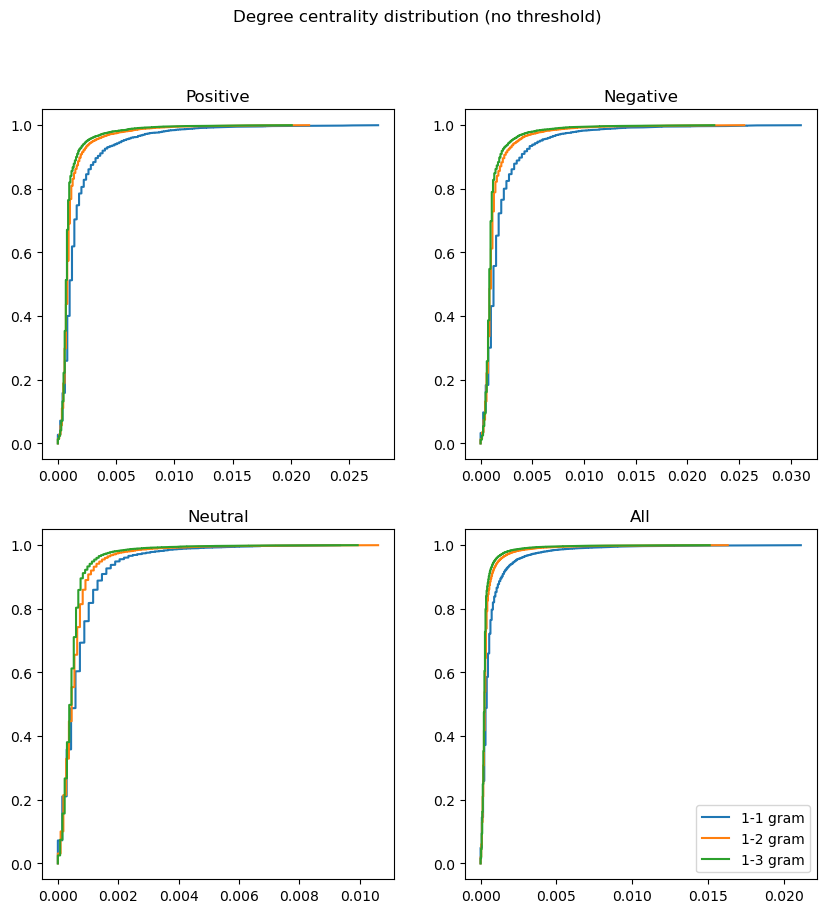

In [41]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 10))

plot_graph_fun(pos_no_thresh_graphs, 'degree_centrality', axes[0,0], 10, ['1-1 gram', '1-2 gram', '1-3 gram'], 'Positive')
plot_graph_fun(neg_no_thresh_graphs, 'degree_centrality', axes[0,1], 10, ['1-1 gram', '1-2 gram', '1-3 gram'], 'Negative')
plot_graph_fun(neu_no_thresh_graphs, 'degree_centrality', axes[1,0], 10, ['1-1 gram', '1-2 gram', '1-3 gram'], 'Neutral')
plot_graph_fun(all_no_thresh_graphs, 'degree_centrality', axes[1,1], 10, ['1-1 gram', '1-2 gram', '1-3 gram'], 'All')
axes[1,1].legend()
fig.suptitle('Degree centrality distribution (no threshold)')
plt.savefig('deg_cent_no_thresh.pdf')

In [ ]:
all_low_thresh_graphs = {key: all_graphs[key] for key in ['graph_all_11_2', 'graph_all_12_2', 'graph_all_13_2']}


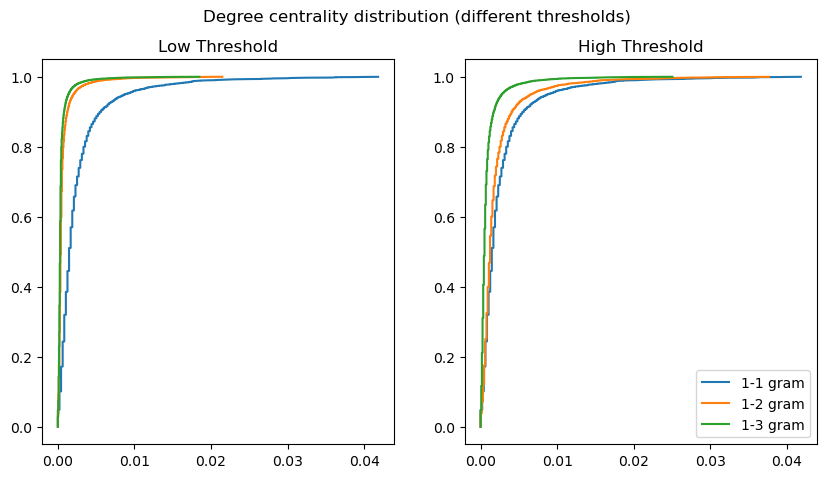

In [74]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))

plot_graph_fun(all_low_thresh_graphs, 'degree_centrality', axes[0], 10, ['1-1 gram', '1-2 gram', '1-3 gram'], 'Low Threshold')
plot_graph_fun(all_med_thresh_graphs, 'degree_centrality', axes[1], 10, ['1-1 gram', '1-2 gram', '1-3 gram'], 'High Threshold')

axes[1].legend()
fig.suptitle('Degree centrality distribution (different thresholds)')
plt.savefig('deg_cent_diff_thresh.pdf')

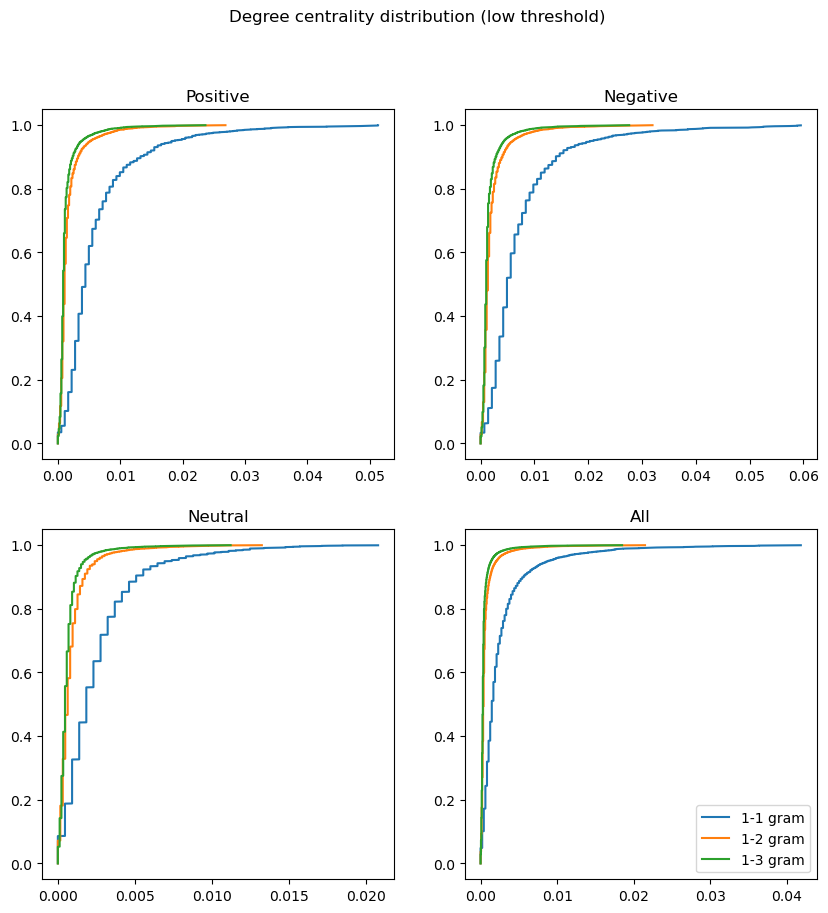

In [42]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 10))

plot_graph_fun(pos_low_thresh_graphs, 'degree_centrality', axes[0,0], 10, ['1-1 gram', '1-2 gram', '1-3 gram'], 'Positive')
plot_graph_fun(neg_low_thresh_graphs, 'degree_centrality', axes[0,1], 10, ['1-1 gram', '1-2 gram', '1-3 gram'], 'Negative')
plot_graph_fun(neu_low_thresh_graphs, 'degree_centrality', axes[1,0], 10, ['1-1 gram', '1-2 gram', '1-3 gram'], 'Neutral')
plot_graph_fun(all_low_thresh_graphs, 'degree_centrality', axes[1,1], 10, ['1-1 gram', '1-2 gram', '1-3 gram'], 'All')
axes[1,1].legend()
fig.suptitle('Degree centrality distribution (low threshold)')
plt.savefig('deg_cent_low_thresh.pdf')

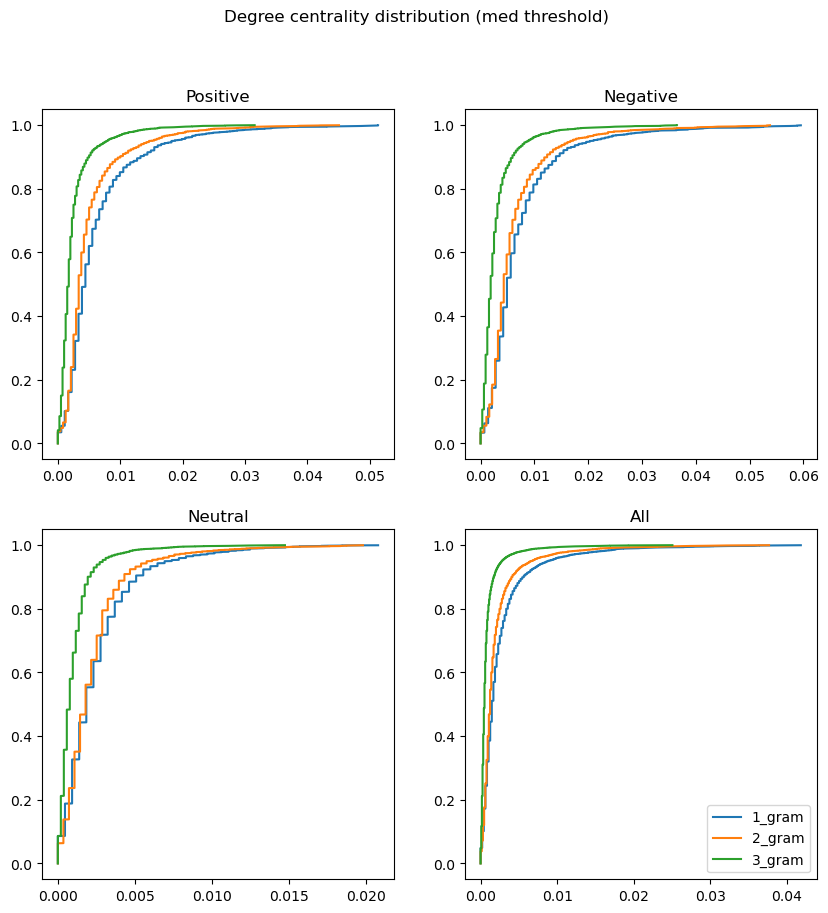

In [43]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 10))

plot_graph_fun(pos_med_thresh_graphs, 'degree_centrality', axes[0,0], 10, ['1_gram', '2_gram', '3_gram'], 'Positive')
plot_graph_fun(neg_med_thresh_graphs, 'degree_centrality', axes[0,1], 10, ['1_gram', '2_gram', '3_gram'], 'Negative')
plot_graph_fun(neu_med_thresh_graphs, 'degree_centrality', axes[1,0], 10, ['1_gram', '2_gram', '3_gram'], 'Neutral')
plot_graph_fun(all_med_thresh_graphs, 'degree_centrality', axes[1,1], 10, ['1_gram', '2_gram', '3_gram'], 'All')
axes[1,1].legend()
fig.suptitle('Degree centrality distribution (med threshold)')
plt.savefig('deg_cent_med_thresh.pdf')

In [44]:
# the node strength (degree scaled for weighting on edges) is much more similar in distribution between the graphs
# this metric may be more robust to changes in the length of ngrams extracted (maybe we can recommend this as a better choice of metric?)

In [45]:
def plot_graph_strength(graphs, axis, offset, labels, sentiment):
    i = 0
    for setup in graphs:
        graph = graphs[setup]
        
        fun_vals = sorted(list(dict(nx.degree(graph, weight = 'weight')).values()))[:-offset]
        cum_distr = np.arange(len(fun_vals))/float(len(fun_vals))
        
        axis.plot(fun_vals, cum_distr, label = labels[i])
        i += 1
    axis.set_title(sentiment)

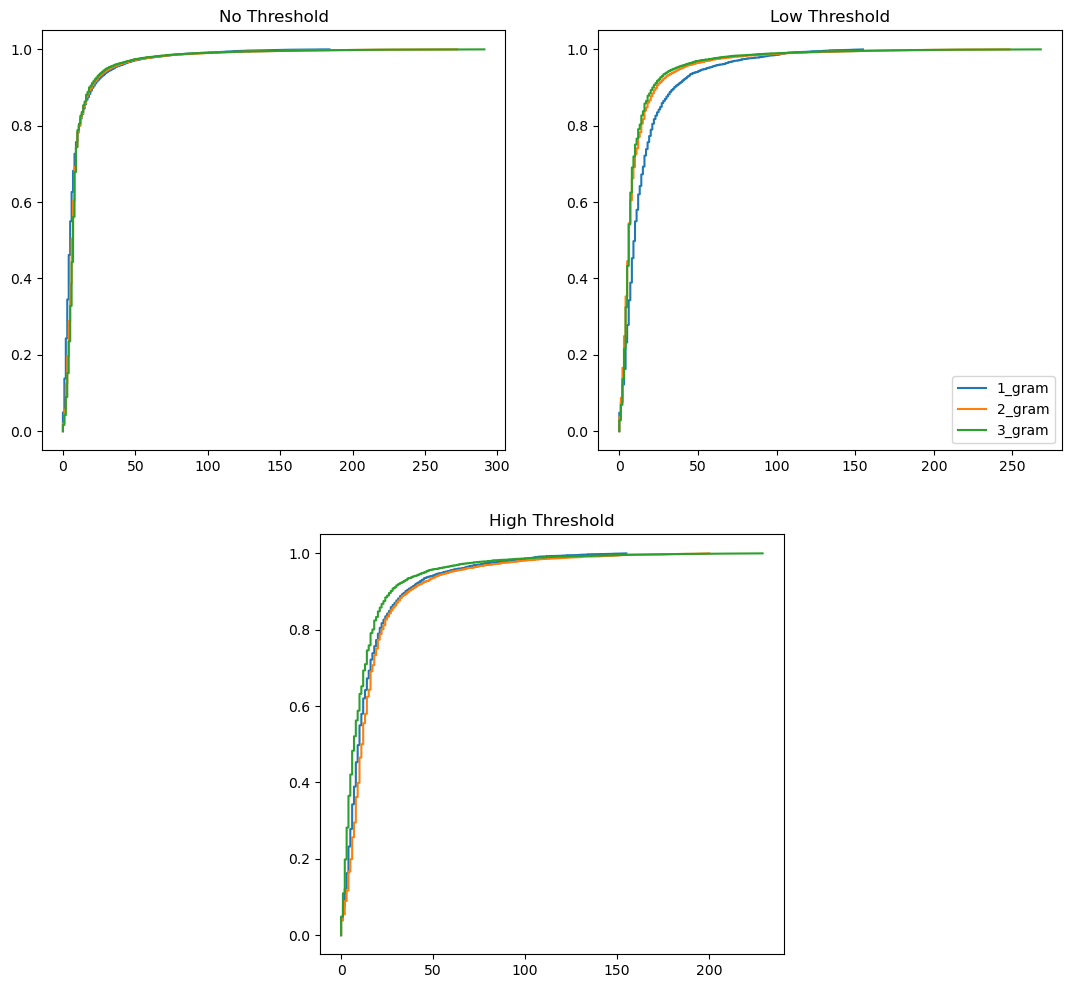

In [82]:
def plot_graph_strength(graphs, axis, offset, labels, sentiment):
    i = 0
    for setup in graphs:
        graph = graphs[setup]
        
        fun_vals = sorted(list(dict(nx.degree(graph, weight = 'weight')).values()))[:-offset]
        cum_distr = np.arange(len(fun_vals))/float(len(fun_vals))
        
        axis.plot(fun_vals, cum_distr, label = labels[i])
        i += 1
    axis.set_title(sentiment)

fig8 = plt.figure(constrained_layout=False, figsize=(12,12))
gs1 = fig8.add_gridspec(nrows=2, ncols=4, left=0.05)
gs1.update(wspace=0.5)

ax1 = plt.subplot(gs1[0, :2], )

plot_graph_strength(all_no_thresh_graphs, ax1, 50, ['1_gram', '2_gram', '3_gram'], 'No Threshold')
ax1.set_title('No Threshold')


ax2 = plt.subplot(gs1[0, 2:])

plot_graph_strength(all_low_thresh_graphs, ax2, 50, ['1_gram', '2_gram', '3_gram'], 'Low Threshold')
ax2.set_title('Low Threshold')


ax3 = plt.subplot(gs1[1, 1:3])

plot_graph_strength(all_med_thresh_graphs, ax3, 50, ['1_gram', '2_gram', '3_gram'], 'High Threshold')
ax3.set_title('High Threshold')


ax2.legend()

#ax1.text(-0.1, 0.95, string.ascii_uppercase[0], transform=ax1.transAxes, 
#            size=20, weight='bold')
#ax2.text(-0.1, 0.95, string.ascii_uppercase[1], transform=ax2.transAxes, 
#            size=20, weight='bold')
#ax3.text(-0.1, 0.95, string.ascii_uppercase[2], transform=ax3.transAxes, 
#            size=20, weight='bold')

plt.savefig('node_str_diff_thresh.pdf')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


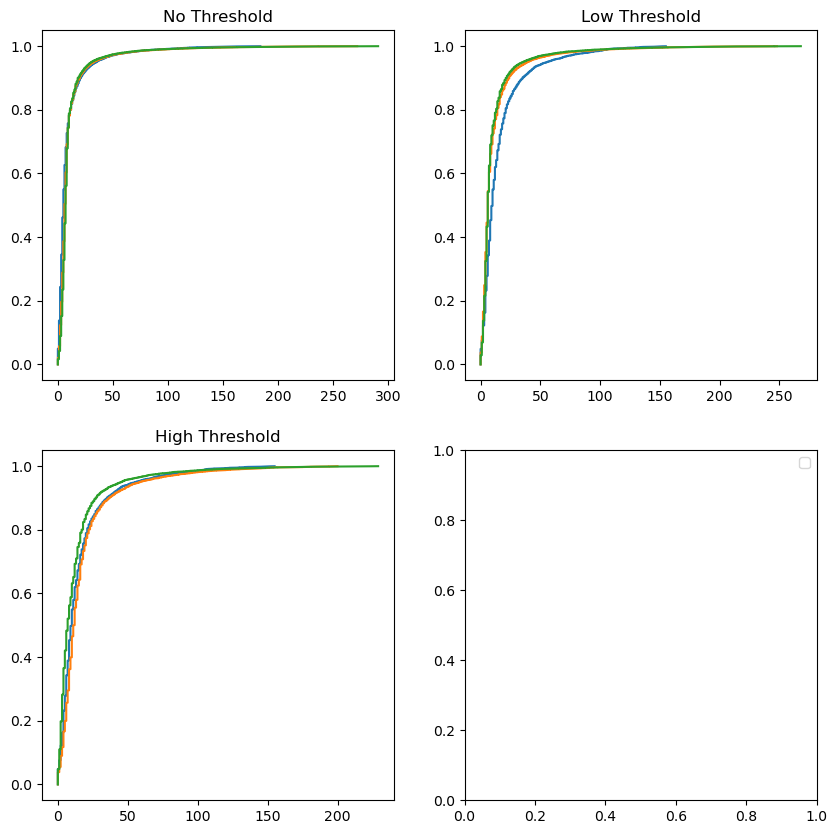

In [76]:
# using a much larger offset, there is still much less difference in the distributions

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 10))

plot_graph_strength(all_no_thresh_graphs, axes[0,0], 50, ['1_gram', '2_gram', '3_gram'], 'No Threshold')
plot_graph_strength(all_low_thresh_graphs, axes[0,1], 50, ['1_gram', '2_gram', '3_gram'], 'Low Threshold')
plot_graph_strength(all_med_thresh_graphs, axes[1,0], 50, ['1_gram', '2_gram', '3_gram'], 'High Threshold')

axes[1,1].legend()
#fig.suptitle('Node strength distribution (no threshold)')

Text(0.5, 0.98, 'Node strength distribution (no threshold)')

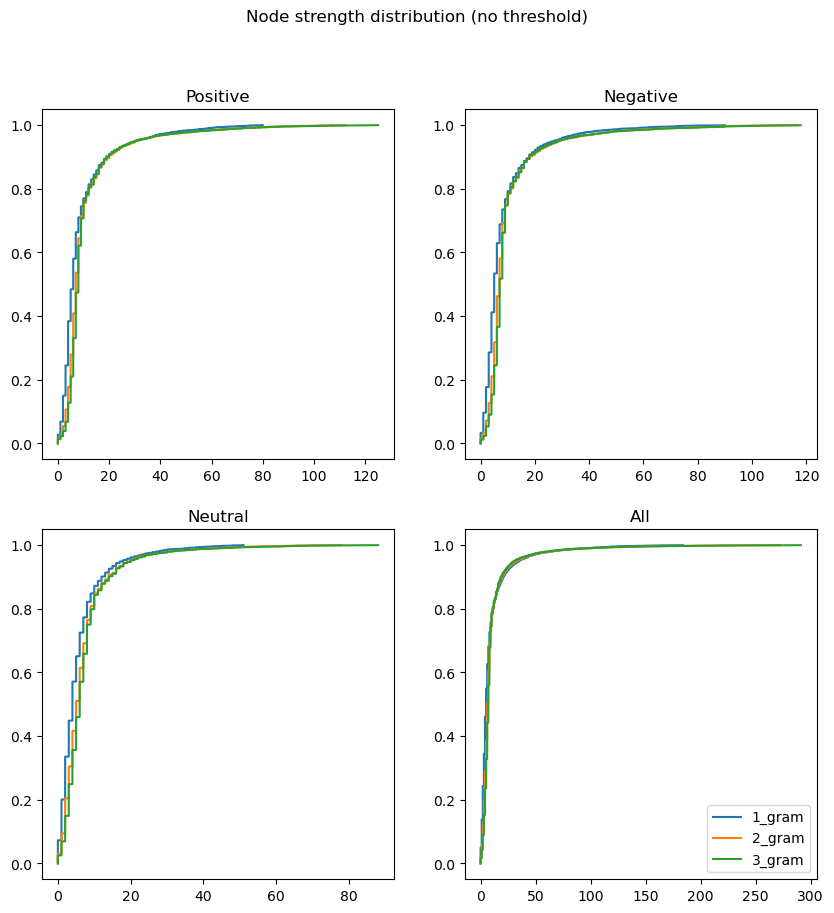

In [46]:
# using a much larger offset, there is still much less difference in the distributions

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 10))

plot_graph_strength(pos_no_thresh_graphs, axes[0,0], 50, ['1_gram', '2_gram', '3_gram'], 'Positive')
plot_graph_strength(neg_no_thresh_graphs, axes[0,1], 50, ['1_gram', '2_gram', '3_gram'], 'Negative')
plot_graph_strength(neu_no_thresh_graphs, axes[1,0], 50, ['1_gram', '2_gram', '3_gram'], 'Neutral')
plot_graph_strength(all_no_thresh_graphs, axes[1,1], 50, ['1_gram', '2_gram', '3_gram'], 'All')

axes[1,1].legend()
fig.suptitle('Node strength distribution (no threshold)')

Text(0.5, 0.98, 'Node strength distribution (low threshold)')

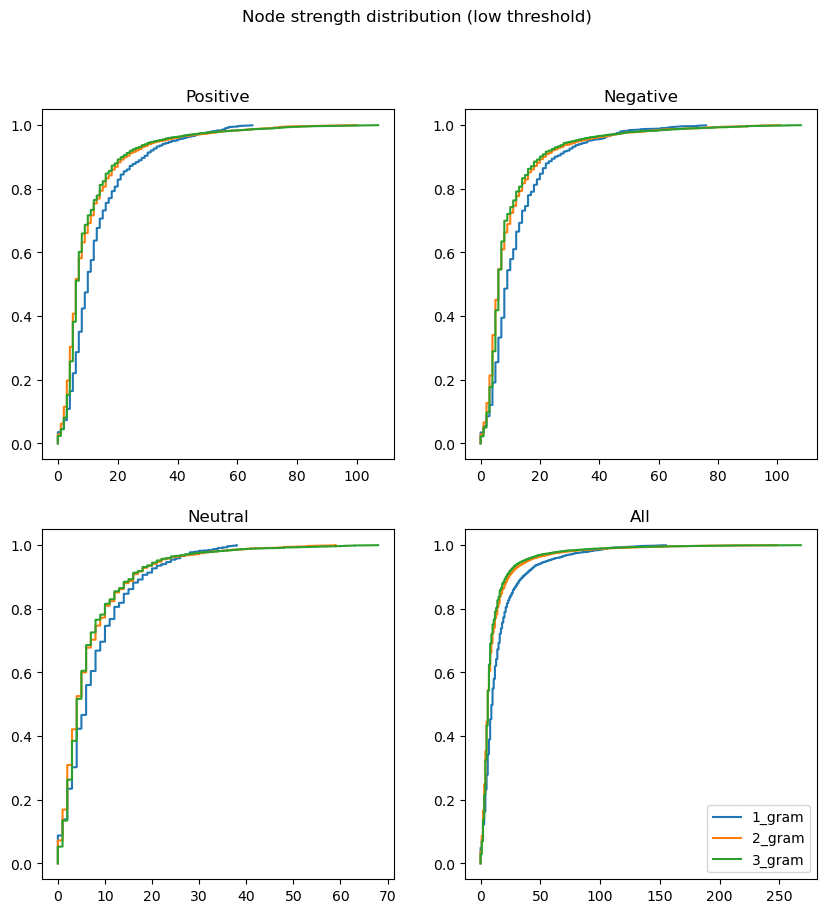

In [47]:
# using a much larger offset, there is still much less difference in the distributions

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 10))

plot_graph_strength(pos_low_thresh_graphs, axes[0,0], 50, ['1_gram', '2_gram', '3_gram'], 'Positive')
plot_graph_strength(neg_low_thresh_graphs, axes[0,1], 50, ['1_gram', '2_gram', '3_gram'], 'Negative')
plot_graph_strength(neu_low_thresh_graphs, axes[1,0], 50, ['1_gram', '2_gram', '3_gram'], 'Neutral')
plot_graph_strength(all_low_thresh_graphs, axes[1,1], 50, ['1_gram', '2_gram', '3_gram'], 'All')

axes[1,1].legend()
fig.suptitle('Node strength distribution (low threshold)')

Text(0.5, 0.98, 'Node strength distribution (med threshold)')

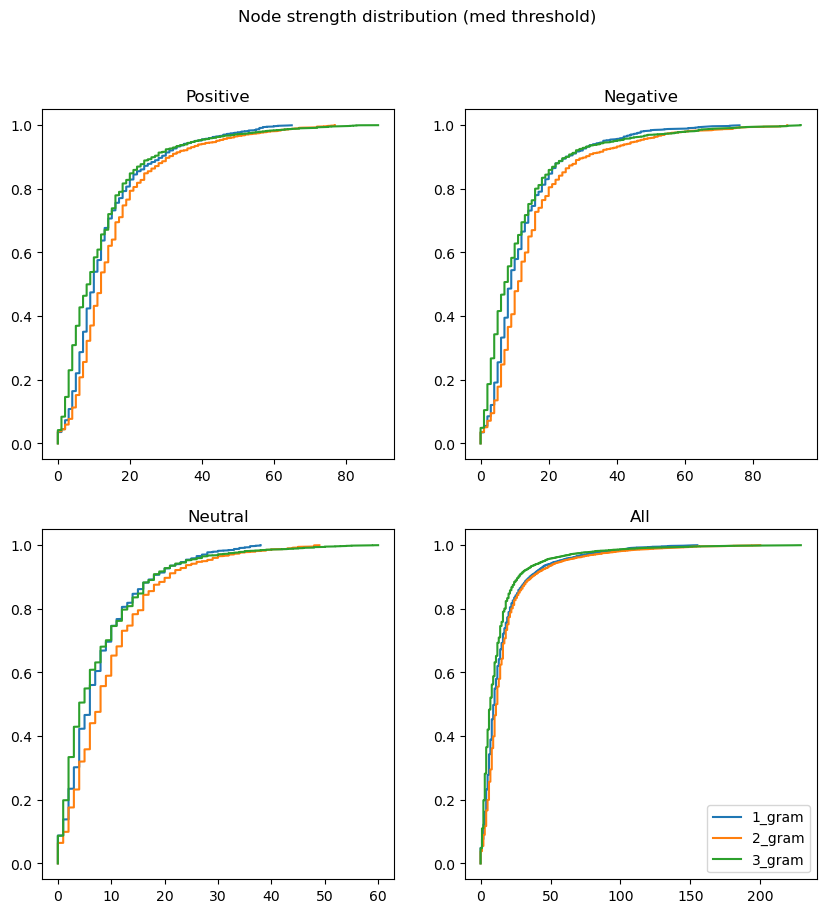

In [48]:
# using a much larger offset, there is still much less difference in the distributions

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 10))

plot_graph_strength(pos_med_thresh_graphs, axes[0,0], 50, ['1_gram', '2_gram', '3_gram'], 'Positive')
plot_graph_strength(neg_med_thresh_graphs, axes[0,1], 50, ['1_gram', '2_gram', '3_gram'], 'Negative')
plot_graph_strength(neu_med_thresh_graphs, axes[1,0], 50, ['1_gram', '2_gram', '3_gram'], 'Neutral')
plot_graph_strength(all_med_thresh_graphs, axes[1,1], 50, ['1_gram', '2_gram', '3_gram'], 'All')

axes[1,1].legend()
fig.suptitle('Node strength distribution (med threshold)')

In [49]:
# the word count distribution (no relation to network topology)
# once again, the differences in distribution are less significant than in the degree centrality distribution
# but they are more different than in the node strength distribution

Text(0.5, 0.98, 'Word count distribution (no threshold)')

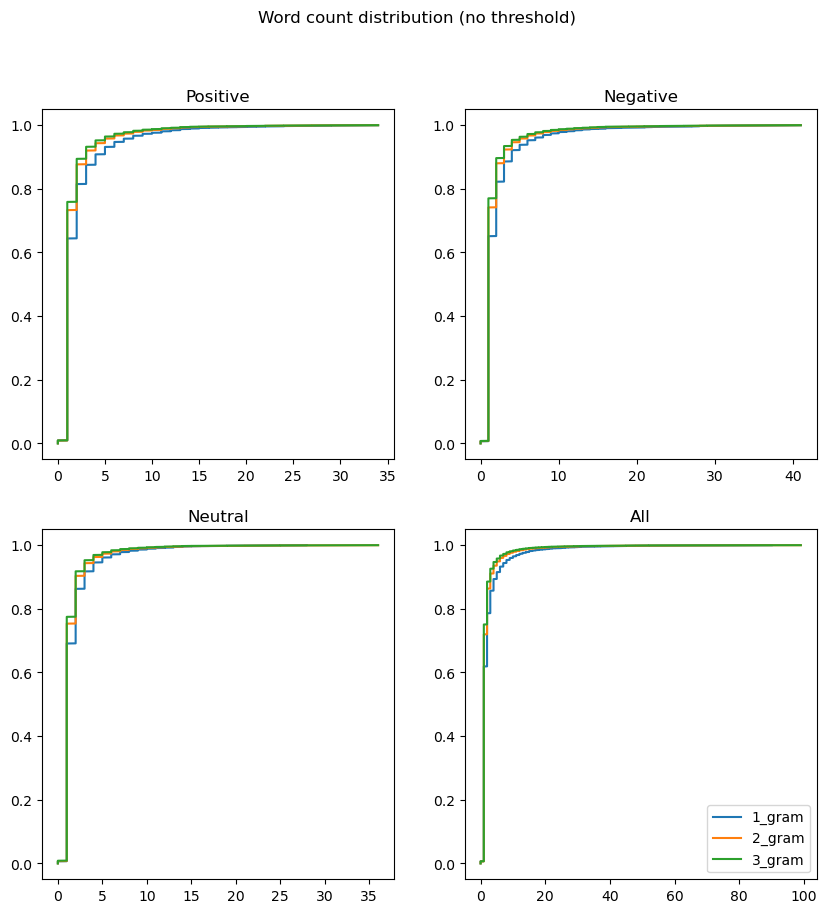

In [50]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 10))

plot_graph_fun(pos_no_thresh_graphs, 'get_node_attributes', axes[0,0], 10, ['1_gram', '2_gram', '3_gram'], 'Positive', 'count')
plot_graph_fun(neg_no_thresh_graphs, 'get_node_attributes', axes[0,1], 10, ['1_gram', '2_gram', '3_gram'], 'Negative', 'count')
plot_graph_fun(neu_no_thresh_graphs, 'get_node_attributes', axes[1,0], 10, ['1_gram', '2_gram', '3_gram'], 'Neutral', 'count')
plot_graph_fun(all_no_thresh_graphs, 'get_node_attributes', axes[1,1], 10, ['1_gram', '2_gram', '3_gram'], 'All', 'count')

axes[1,1].legend()
fig.suptitle('Word count distribution (no threshold)')

Text(0.5, 0.98, 'Word count distribution (low threshold)')

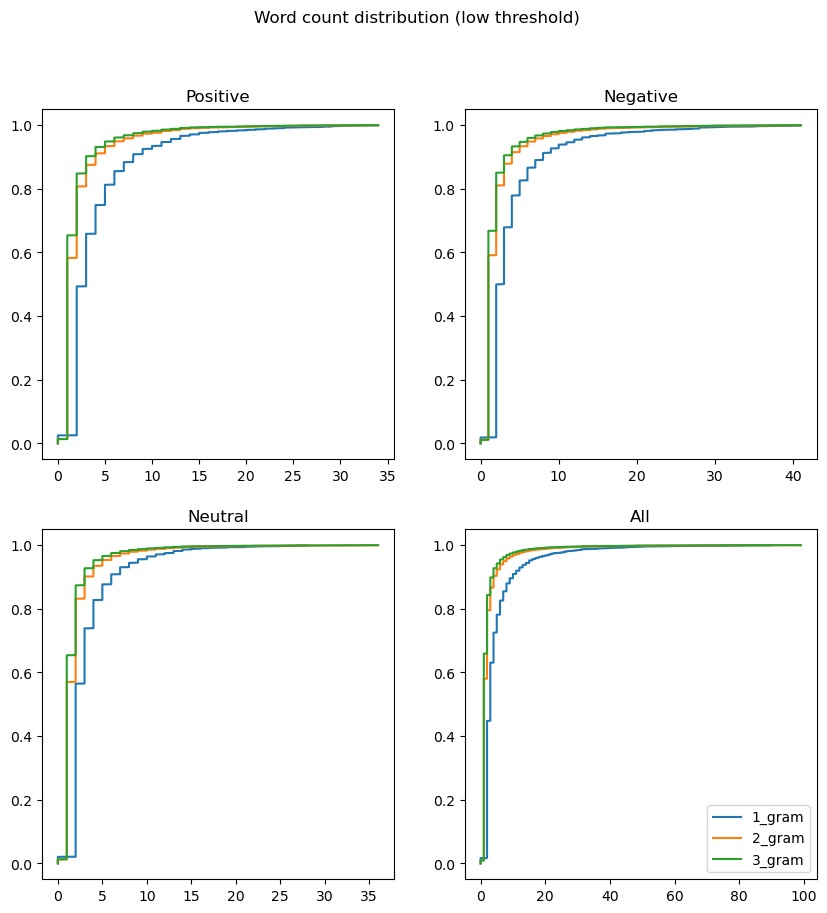

In [51]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 10))

plot_graph_fun(pos_low_thresh_graphs, 'get_node_attributes', axes[0,0], 10, ['1_gram', '2_gram', '3_gram'], 'Positive', 'count')
plot_graph_fun(neg_low_thresh_graphs, 'get_node_attributes', axes[0,1], 10, ['1_gram', '2_gram', '3_gram'], 'Negative', 'count')
plot_graph_fun(neu_low_thresh_graphs, 'get_node_attributes', axes[1,0], 10, ['1_gram', '2_gram', '3_gram'], 'Neutral', 'count')
plot_graph_fun(all_low_thresh_graphs, 'get_node_attributes', axes[1,1], 10, ['1_gram', '2_gram', '3_gram'], 'All', 'count')

axes[1,1].legend()
fig.suptitle('Word count distribution (low threshold)')

Text(0.5, 0.98, 'Word count distribution (med threshold)')

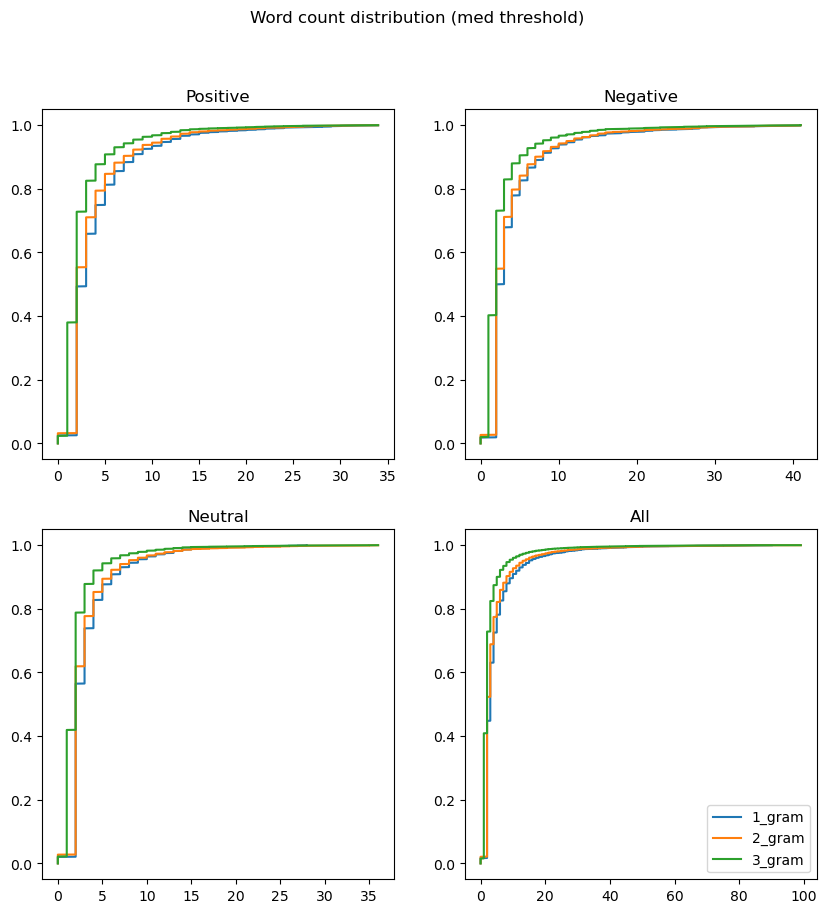

In [52]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 10))

plot_graph_fun(pos_med_thresh_graphs, 'get_node_attributes', axes[0,0], 10, ['1_gram', '2_gram', '3_gram'], 'Positive', 'count')
plot_graph_fun(neg_med_thresh_graphs, 'get_node_attributes', axes[0,1], 10, ['1_gram', '2_gram', '3_gram'], 'Negative', 'count')
plot_graph_fun(neu_med_thresh_graphs, 'get_node_attributes', axes[1,0], 10, ['1_gram', '2_gram', '3_gram'], 'Neutral', 'count')
plot_graph_fun(all_med_thresh_graphs, 'get_node_attributes', axes[1,1], 10, ['1_gram', '2_gram', '3_gram'], 'All', 'count')

axes[1,1].legend()
fig.suptitle('Word count distribution (med threshold)')

In [53]:
# the paper also looks at words happiness and distributions based on this, not sure how difficult this is to do

In [83]:
# measuring the tendency of nodes to connect to each other based on certain attributes

def generate_network_assort_table(graphs):
    network_prop_df = pd.DataFrame(columns = ['setup', 'strength', 'degree', 'count'])
    for setup in graphs:
        graph = graphs[setup]
        strength = nx.degree_assortativity_coefficient(graph, weight = 'weight')
        degree_coeff = nx.degree_assortativity_coefficient(graph)
        count_coeff = nx.attribute_assortativity_coefficient(graph, 'count')
        
        network_prop_df = pd.concat([network_prop_df, pd.DataFrame.from_dict({'setup': setup, 'strength': [strength], 'degree': [degree_coeff]
                                            ,'count': [count_coeff]})], ignore_index = True)
        
    return network_prop_df

In [55]:
# we compare how nodes tend to connect to each other based on their attributes
# there are significant differences in these metrics with the length 1 and length 3 graphs
# e.g. for 'count' on the positive graphs, the assortivity is >4x higher on the length 3 graph
# this difference is less pronounced on the all graph (difference of 2x)
# these differences are less in the 'strength' and 'degree' metrics, even though the degree metric showed a drastically different dist

In [56]:
generate_network_assort_table(no_score_thresh_graphs)

,setup,strength,degree,count
0,graph_pos_33_1,0.942828,0.913353,0.592351
1,graph_neg_33_1,0.792157,0.810278,0.482054
2,graph_neu_33_1,0.910711,0.958497,0.613894
3,graph_all_33_1,0.815191,0.796098,0.499287
4,graph_pos_33_2,0.942828,0.913353,0.592351
5,graph_neg_33_2,0.792157,0.810278,0.482054
6,graph_neu_33_2,0.910711,0.958497,0.613894
7,graph_all_33_2,0.815191,0.796098,0.499287
8,graph_pos_33_5,0.942828,0.913353,0.592351
9,graph_neg_33_5,0.792157,0.810278,0.482054


In [57]:
generate_network_assort_table(low_thresh_graphs)

,setup,strength,degree,count
0,graph_pos_11_2,-0.038626,-0.028844,0.008093
1,graph_neg_11_2,-0.028913,-0.032664,0.012256
2,graph_neu_11_2,0.017027,0.088768,0.036793
3,graph_all_11_2,-0.018607,-0.006406,0.012591
4,graph_pos_12_2,-0.020410,-0.018005,0.038512
5,graph_neg_12_2,-0.027291,-0.031947,0.042467
6,graph_neu_12_2,0.009012,0.017662,0.083819
7,graph_all_12_2,-0.019712,-0.016889,0.032185
8,graph_pos_13_2,-0.013913,-0.012635,0.056331
9,graph_neg_13_2,-0.022713,-0.026693,0.057680


In [58]:
generate_network_assort_table(med_thresh_graphs)

NameError: name 'med_thresh_graphs' is not defined

In [31]:
# because we have done n gram extraction, we are unlikely to observed filler words and thus do not need to filter
# as aggresively

In [32]:
def plot_community_counts(graphs, axes, num_communities, labels):
    i = 0
    for setup in graphs:
        graph = graphs[setup]
        
        communities = nx.community.louvain_communities(graph, seed = 1)
        communities.sort(key = len)
        
        j = 0
        for community in communities[-1:-(num_communities+1):-1]:
            subgraph = graph.subgraph(community)
            
            node_count = nx.get_node_attributes(subgraph, 'count')
            node_count_sorted=dict(sorted(node_count.items(), key=lambda item: item[1],reverse=True))
        
            top_keys = list(node_count_sorted.keys())[0:15]
            top_keys.reverse()
            top_values = list(node_count_sorted.values())[0:15]
            top_values.reverse()
            total_count = np.sum(list(node_count_sorted.values()))
                        
            axes[i][j].barh(top_keys, top_values/total_count)
            #axes[i][j].tick_params(axis='y',direction='in')
            
            if j == 0:
                axes[i,0].set_ylabel(labels[i], fontsize = 15)
            
            j += 1
        
        i += 1

In [33]:
# the community structure for the biggest communities within the graphs are similar between the different setups
# the biggest communities seem to come from the filler keywords like 'rt' and 'amp'
# it is reasonable to expect that these communities should be similar between the graphs due to the 3gram graph also having the 1gram graph

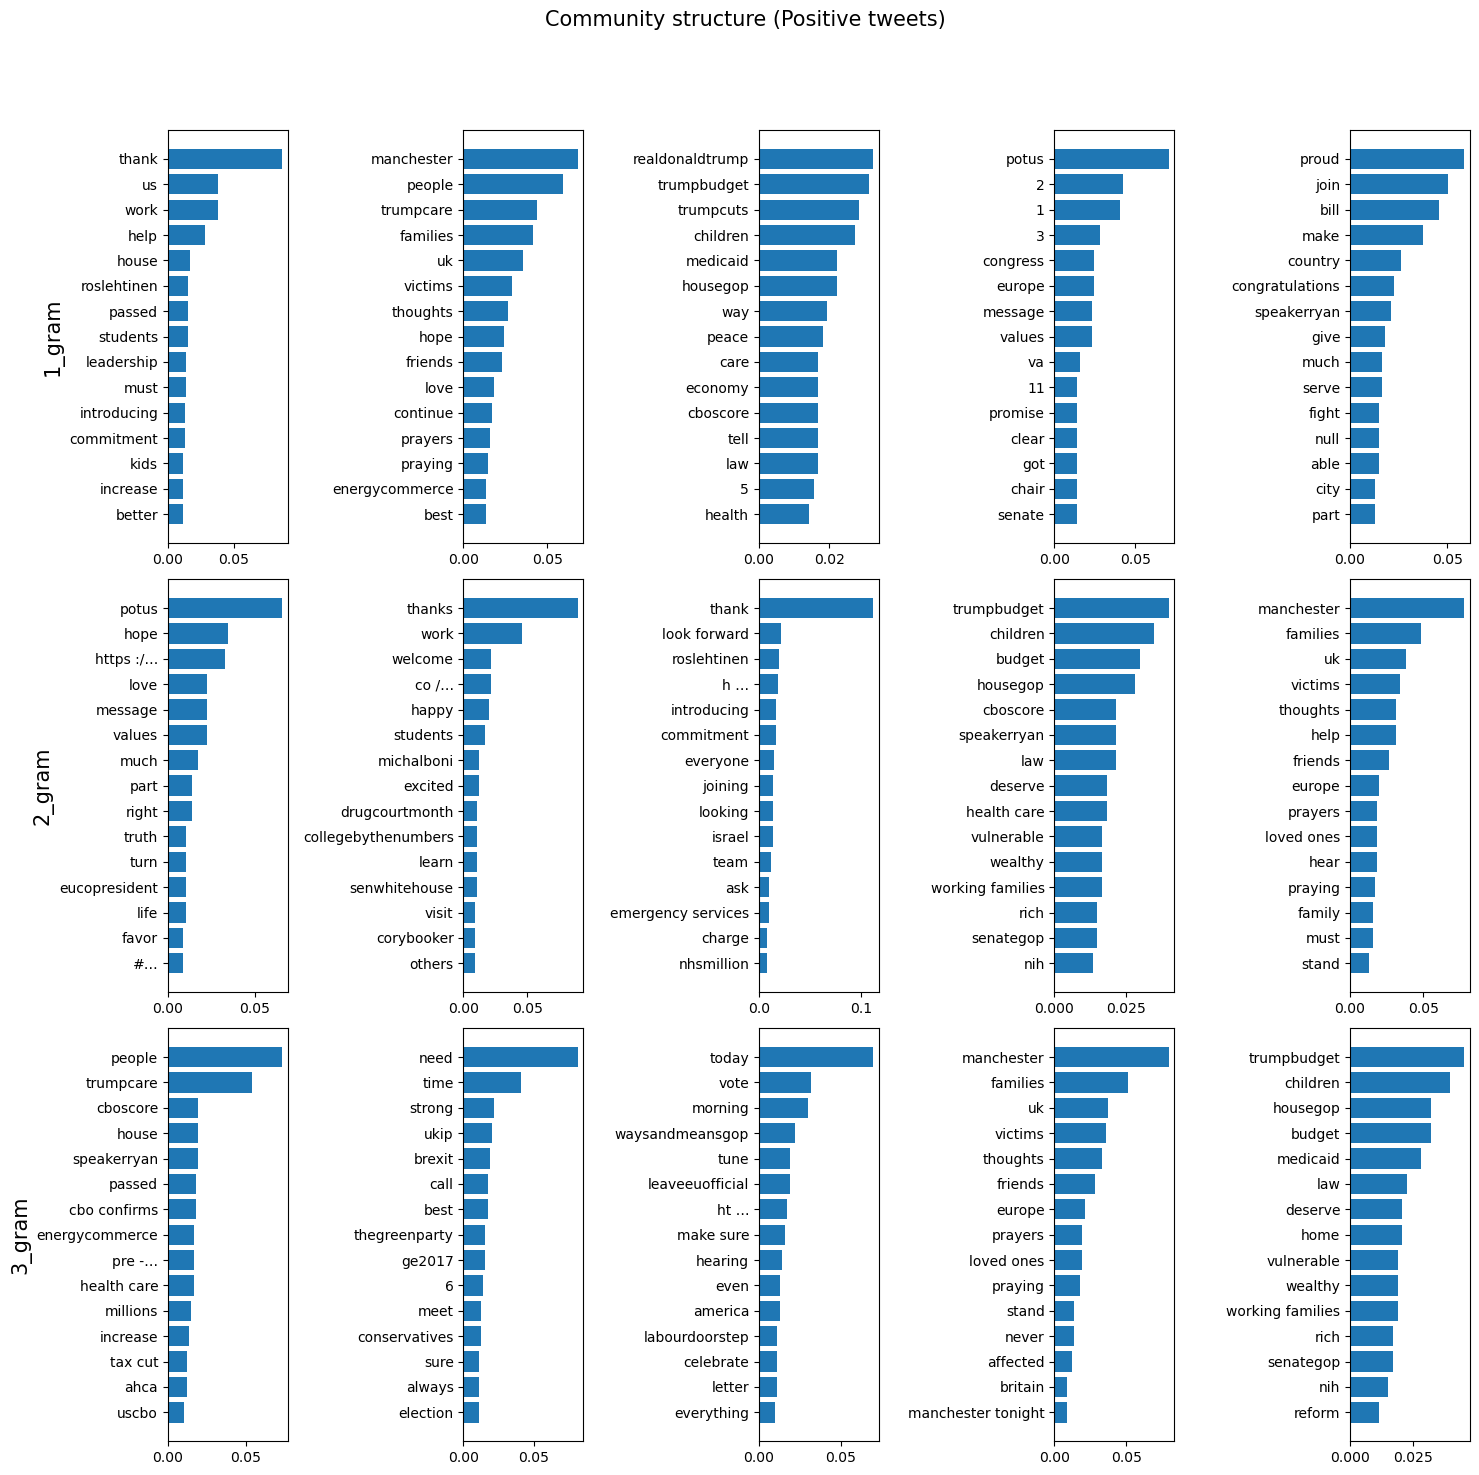

In [34]:
fig, axes = plt.subplots(nrows = 3, ncols = 5, figsize = (15, 15))

plot_community_counts(pos_no_thresh_graphs, axes, 5, ['1_gram', '2_gram', '3_gram'])
fig.suptitle('Community structure (Positive tweets)', fontsize = 15)
fig.tight_layout()
fig.subplots_adjust(top=0.90)

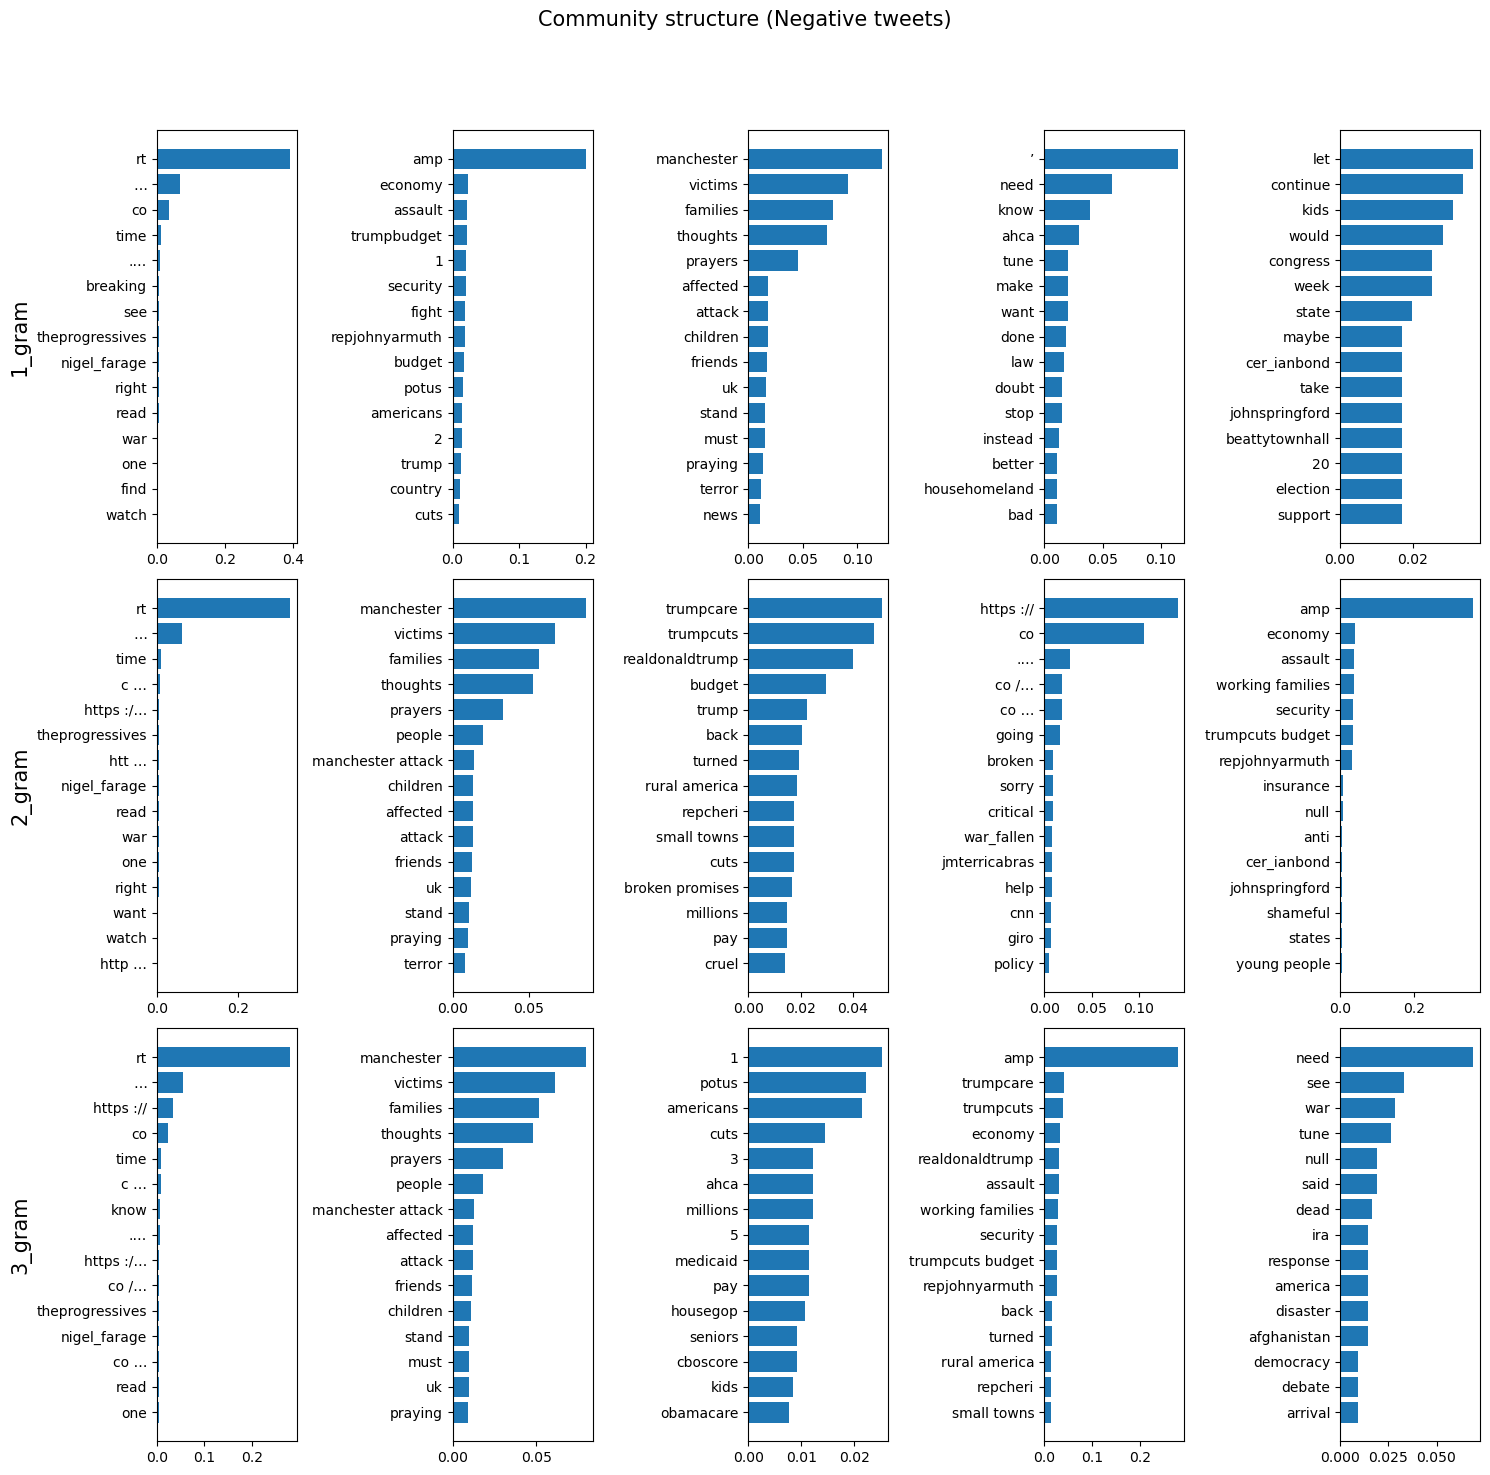

In [32]:
fig, axes = plt.subplots(nrows = 3, ncols = 5, figsize = (15, 15))

plot_community_counts(neg_no_thresh_graphs, axes, 5, ['1_gram', '2_gram', '3_gram'])
fig.suptitle('Community structure (Negative tweets)', fontsize = 15)
fig.tight_layout()
fig.subplots_adjust(top=0.90)

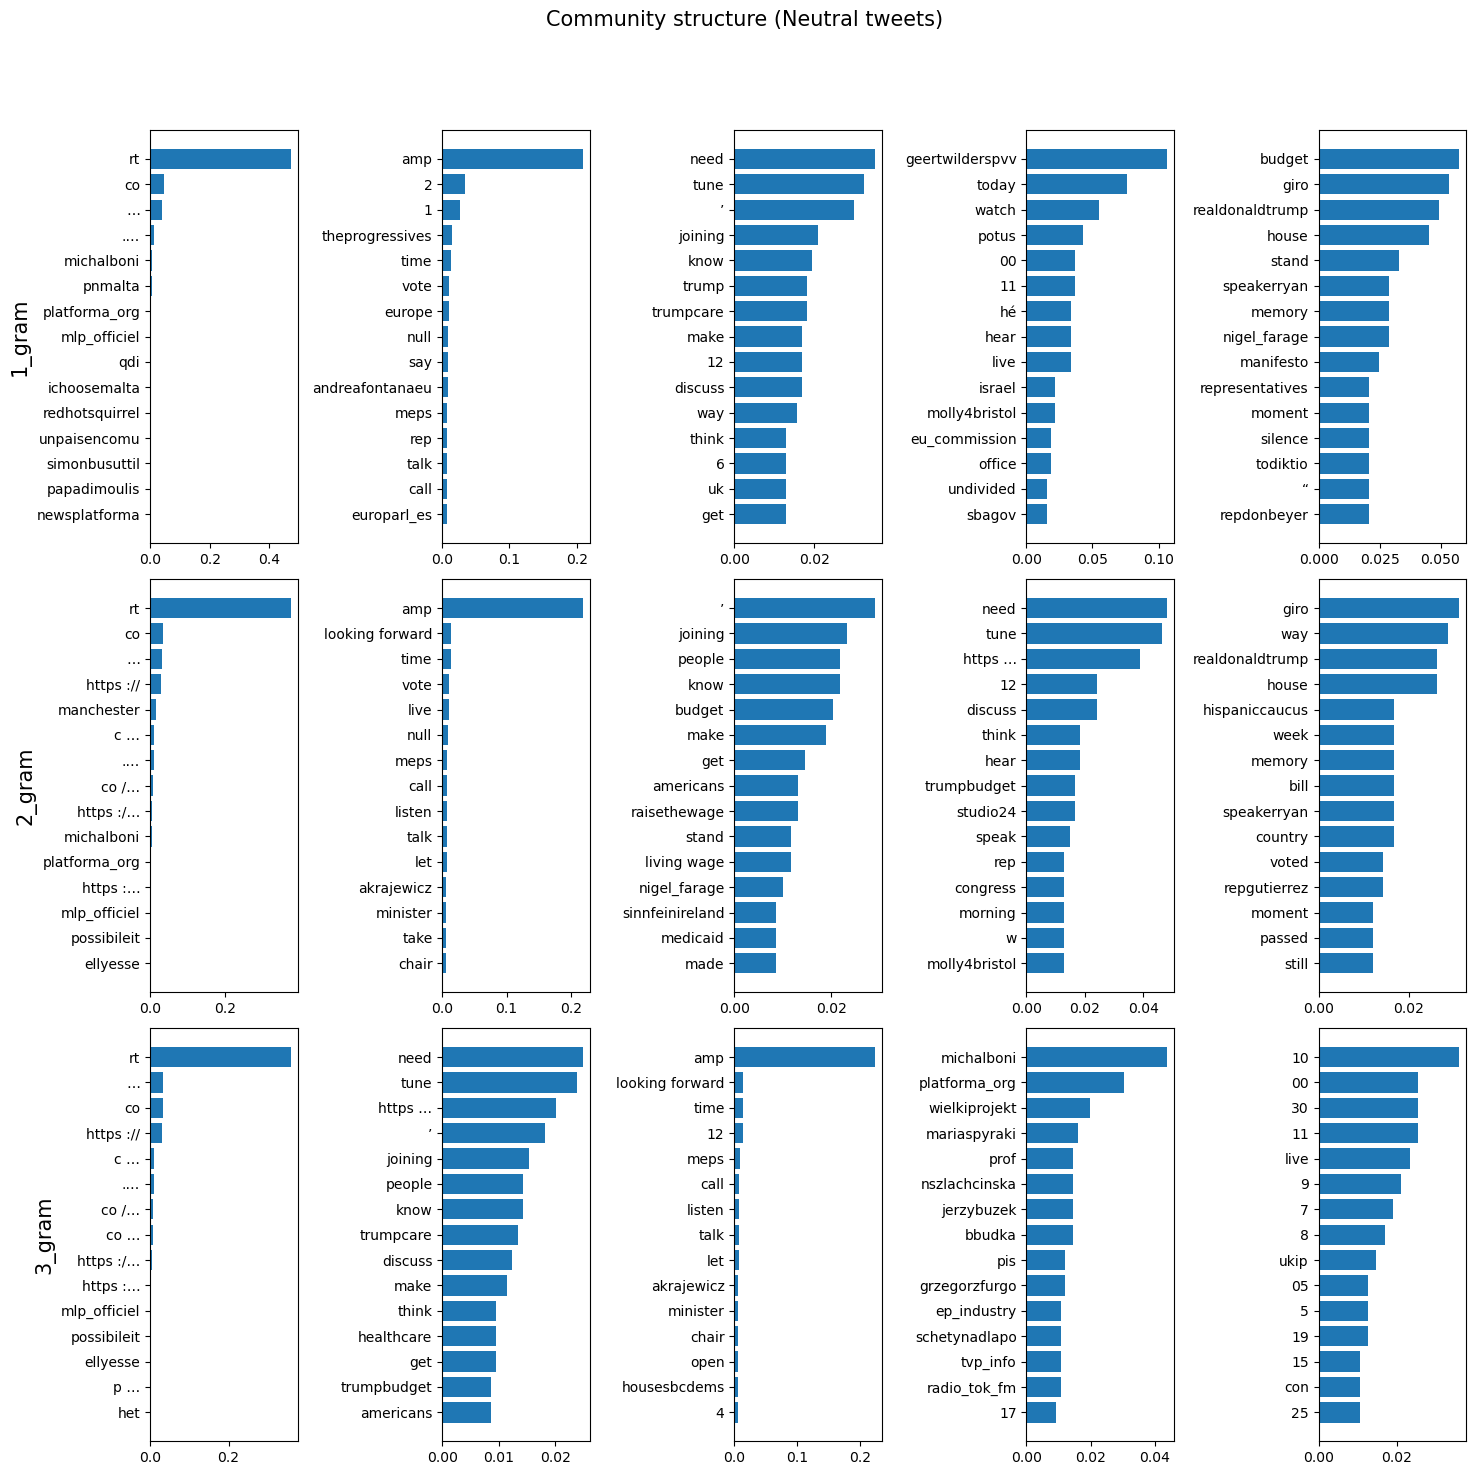

In [33]:
fig, axes = plt.subplots(nrows = 3, ncols = 5, figsize = (15, 15))

plot_community_counts(neu_no_thresh_graphs, axes, 5, ['1_gram', '2_gram', '3_gram'])
fig.suptitle('Community structure (Neutral tweets)', fontsize = 15)
fig.tight_layout()
fig.subplots_adjust(top=0.90)

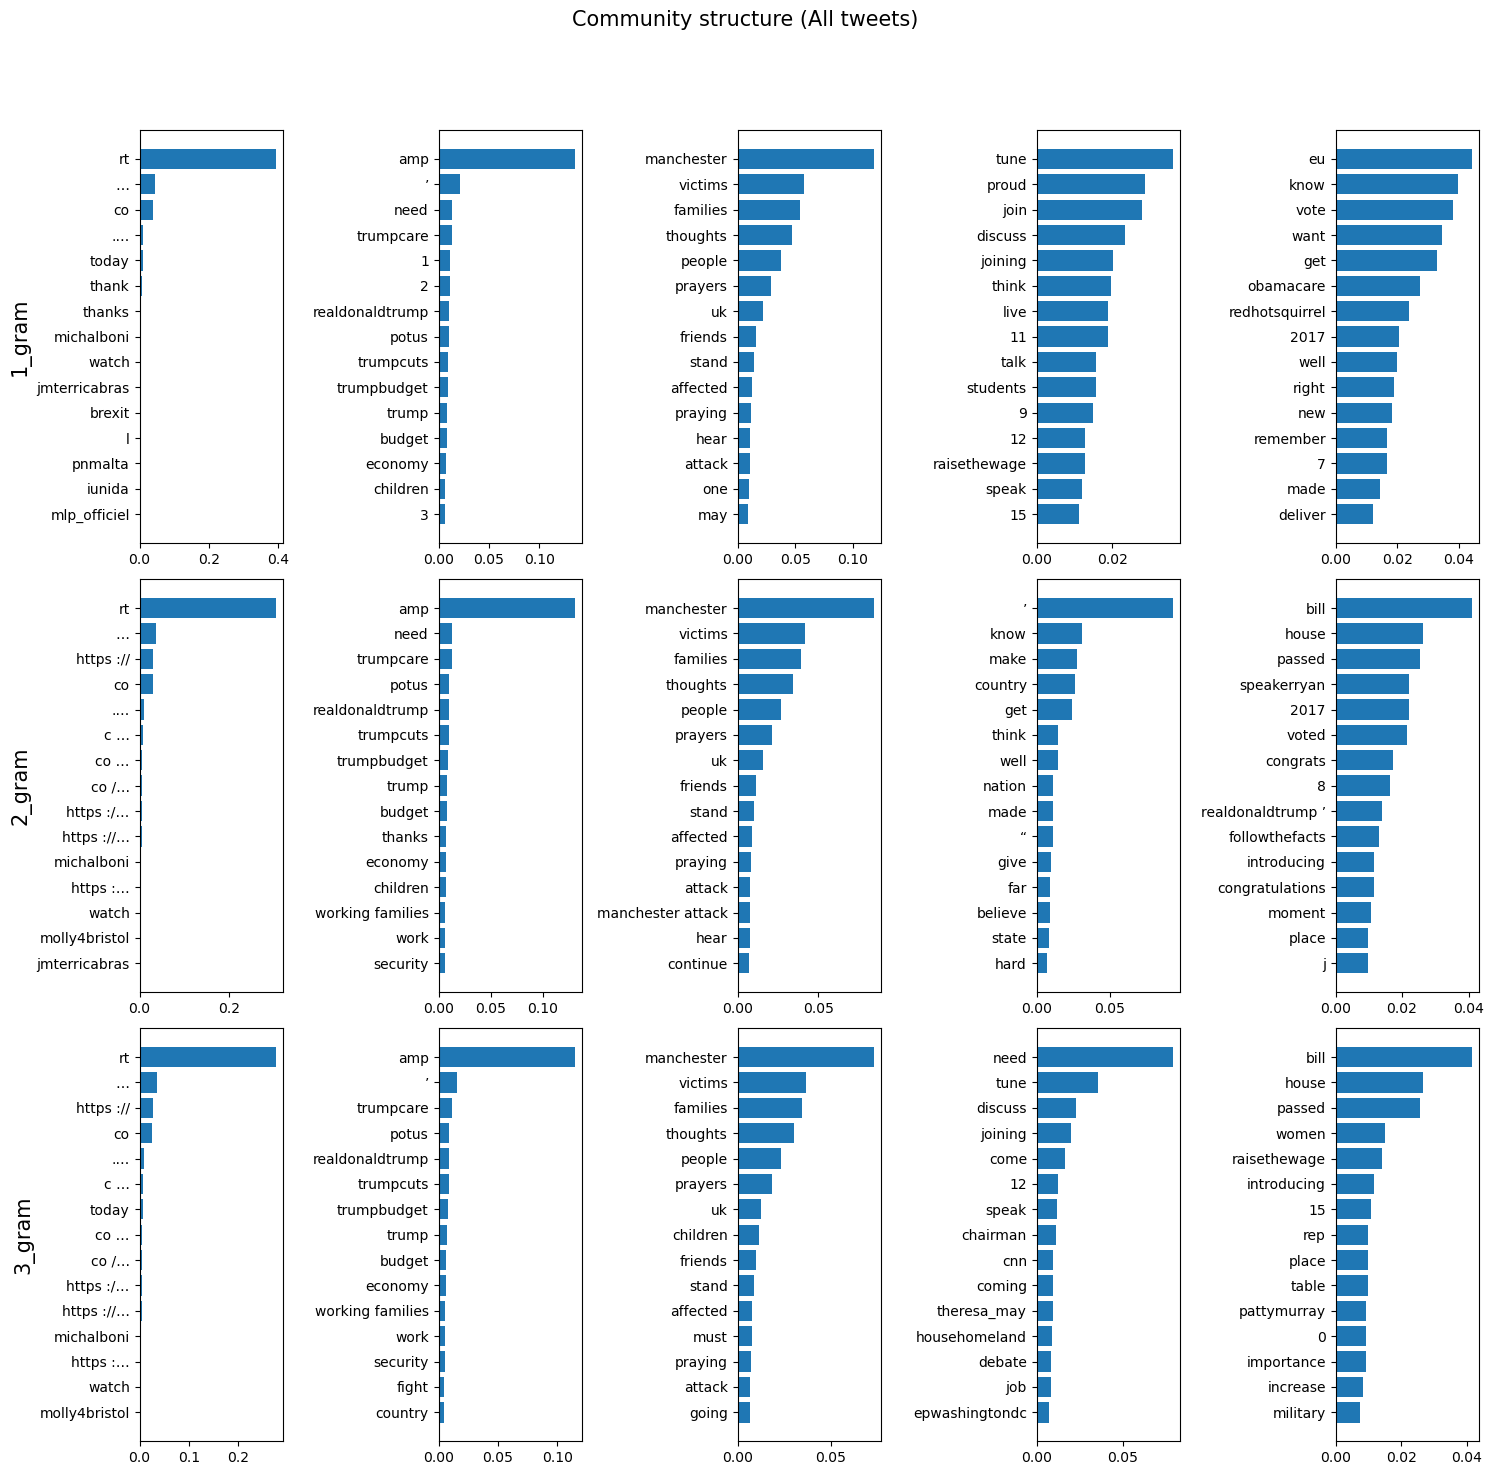

In [34]:
fig, axes = plt.subplots(nrows = 3, ncols = 5, figsize = (15, 15))

plot_community_counts(all_no_thresh_graphs, axes, 5, ['1_gram', '2_gram', '3_gram'])
fig.suptitle('Community structure (All tweets)', fontsize = 15)
fig.tight_layout()
fig.subplots_adjust(top=0.90)

In [35]:
def sorted_cent(graphs, topN, calc_eig = False, calc_close = False):
    degCent_df = pd.DataFrame()
    nodeStr_df = pd.DataFrame()
    nodeCount_df = pd.DataFrame()
    eigCent_df = pd.DataFrame()
    closeCent_df = pd.DataFrame()
    
    for setup in graphs:
        
        graph = graphs[setup]
        
        degCent = nx.degree_centrality(graph)
        degCent_sorted=dict(sorted(degCent.items(), key=lambda item: item[1],reverse=True))
        
        degCent_df[setup] = list(degCent_sorted.keys())[0:topN]

        #Computing node strength
        nodeStr = nx.degree(graph, weight = 'weight')
        nodeStr_sorted = dict(sorted(dict(nodeStr).items(), key=lambda item: item[1],reverse=True))
        
        nodeStr_df[setup] = list(nodeStr_sorted.keys())[0:topN]

        nodeCount = nx.get_node_attributes(graph, 'count')
        nodeCount_sorted = dict(sorted(nodeCount.items(), key=lambda item: item[1],reverse=True))
        
        nodeCount_df[setup] = list(nodeCount_sorted.keys())[0:topN]

        if calc_eig:
        #Computing betweeness
            eigCent = nx.eigenvector_centrality_numpy(graph, weight='weight')
            eigCent_sorted=dict(sorted(eigCent.items(), key=lambda item: item[1],reverse=True))

            eigCent_df[setup] = list(eigCent_sorted.keys())[0:topN]

        if calc_close:
        #Computing betweeness
            closeCent = nx.closeness_centrality(graph)
            closeCent_sorted=dict(sorted(closeCent.items(), key=lambda item: item[1],reverse=True))

            closeCent_df[setup] = list(closeCent_sorted.keys())[0:topN]
        
    return degCent_df, nodeStr_df, nodeCount_df, eigCent_df, closeCent_df

In [36]:
from IPython.display import display_html
from itertools import chain,cycle
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2 style="text-align: center;">{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

In [37]:
pos_degCent_df, pos_nodeStr_df, pos_nodeCount_df, pos_eigCent_df, pos_closeCent_df = sorted_cent(pos_no_thresh_graphs, 25)

In [38]:
# the most significant nodes show similar behaviour to what was seen earlier, with the same nodes generally being most important in different graphs
# some words can be quite different in their placement e.g. 'bill'

In [39]:
display_side_by_side(pos_degCent_df, pos_nodeStr_df, pos_nodeCount_df, titles = ['deg cent', 'node str', 'node count'])

,graph_pos_1_2,graph_pos_2_2,graph_pos_3_2
0,thank,thank,thank
1,thanks,thanks,thanks
2,need,need,need
3,today,today,today
4,want,manchester,manchester
5,manchester,want,potus
6,join,potus,support
7,potus,support,want
8,work,people,proud
9,support,join,join


In [40]:
neg_degCent_df, neg_nodeStr_df, neg_nodeCount_df, neg_eigCent_df, neg_closeCent_df = sorted_cent(neg_no_thresh_graphs, 25)

In [41]:
display_side_by_side(neg_degCent_df, neg_nodeStr_df, neg_nodeCount_df, titles = ['deg cent', 'node str', 'node count'])

,graph_neg_1_0,graph_neg_2_0,graph_neg_3_0
0,rt,rt,rt
1,amp,amp,amp
2,…,…,…
3,manchester,manchester,manchester
4,’,https ://,https ://
5,victims,co,co
6,families,victims,victims
7,co,families,families
8,thoughts,’,’
9,trumpbudget,thoughts,thoughts


In [42]:
neu_degCent_df, neu_nodeStr_df, neu_nodeCount_df, neu_eigCent_df, neu_closeCent_df = sorted_cent(neu_no_thresh_graphs, 25)

In [43]:
display_side_by_side(neu_degCent_df, neu_nodeStr_df, neu_nodeCount_df, titles = ['deg cent', 'node str', 'node count'])

,graph_neu_1_0,graph_neu_2_0,graph_neu_3_0
0,rt,rt,rt
1,amp,amp,amp
2,…,co,co
3,co,https ://,…
4,.…,…,https ://
5,manchester,c …,c …
6,tune,.…,.…
7,need,manchester,manchester
8,today,co …,co /…
9,’,https ://…,co …


In [44]:
all_degCent_df, all_nodeStr_df, all_nodeCount_df, all_eigCent_df, all_closeCent_df = sorted_cent(all_no_thresh_graphs, 25)

In [45]:
display_side_by_side(all_degCent_df, all_nodeStr_df, all_nodeCount_df, titles = ['deg cent', 'node str', 'node count'])

,graph_all_1_0,graph_all_2_0,graph_all_3_0
0,rt,rt,rt
1,amp,amp,amp
2,…,…,…
3,co,co,co
4,’,https ://,https ://
5,manchester,manchester,manchester
6,need,’,’
7,today,need,need
8,.…,today,today
9,families,families,.…
